In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [4]:
df = pd.read_csv('mental-health-in-tech.csv')

In [5]:
pd.set_option('display.max_columns', None) 

In [6]:
df.head()

Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                1.0              

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                NaN                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                NaN                                                
1                                                Yes                                                
2                                                NaN                                                
3                                                NaN                                                
4                                                Yes                                                

  Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                 No                                                                                       
1                                                Yes                                                                                       
2                                                 No                                                                                       
3                                                NaN                                                                                       
4                                                 No                                                                                       

  Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                 No                                                            
1                                                Yes                                                            
2                                                 No                                                            
3                                                NaN                                                            
4                                                 No                                                            

  Is your anonymi

In [7]:
pd.reset_option('display.max_columns')

In [8]:
for column in df.columns:
    print(f"Column: {column}  \nData Type: {df[column].dtype}\n___________________________________________")

Column: Are you self-employed?  
Data Type: int64
___________________________________________
Column: How many employees does your company or organization have?  
Data Type: object
___________________________________________
Column: Is your employer primarily a tech company/organization?  
Data Type: float64
___________________________________________
Column: Is your primary role within your company related to tech/IT?  
Data Type: float64
___________________________________________
Column: Does your employer provide mental health benefits as part of healthcare coverage?  
Data Type: object
___________________________________________
Column: Do you know the options for mental health care available under your employer-provided coverage?  
Data Type: object
___________________________________________
Column: Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  
Data Type: object
___________________________

C:\Users\bugra\AppData\Local\Temp\ipykernel_11836\3846875921.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


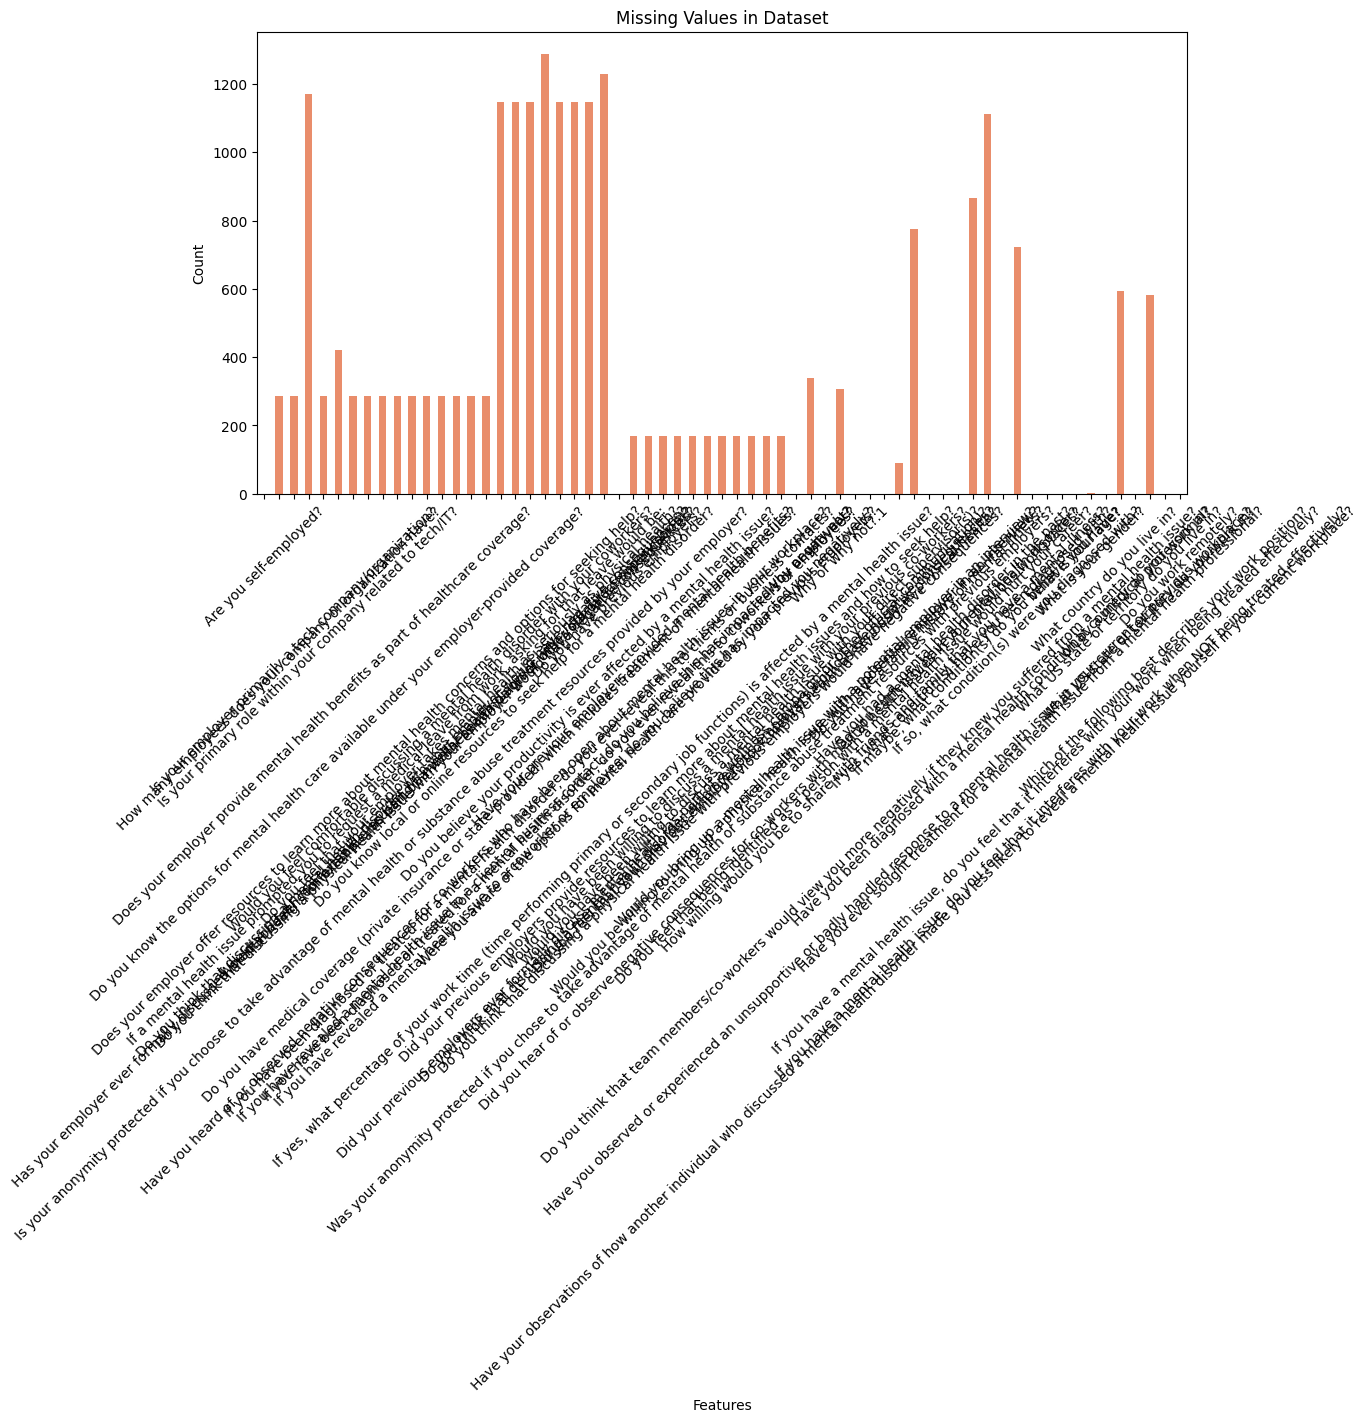

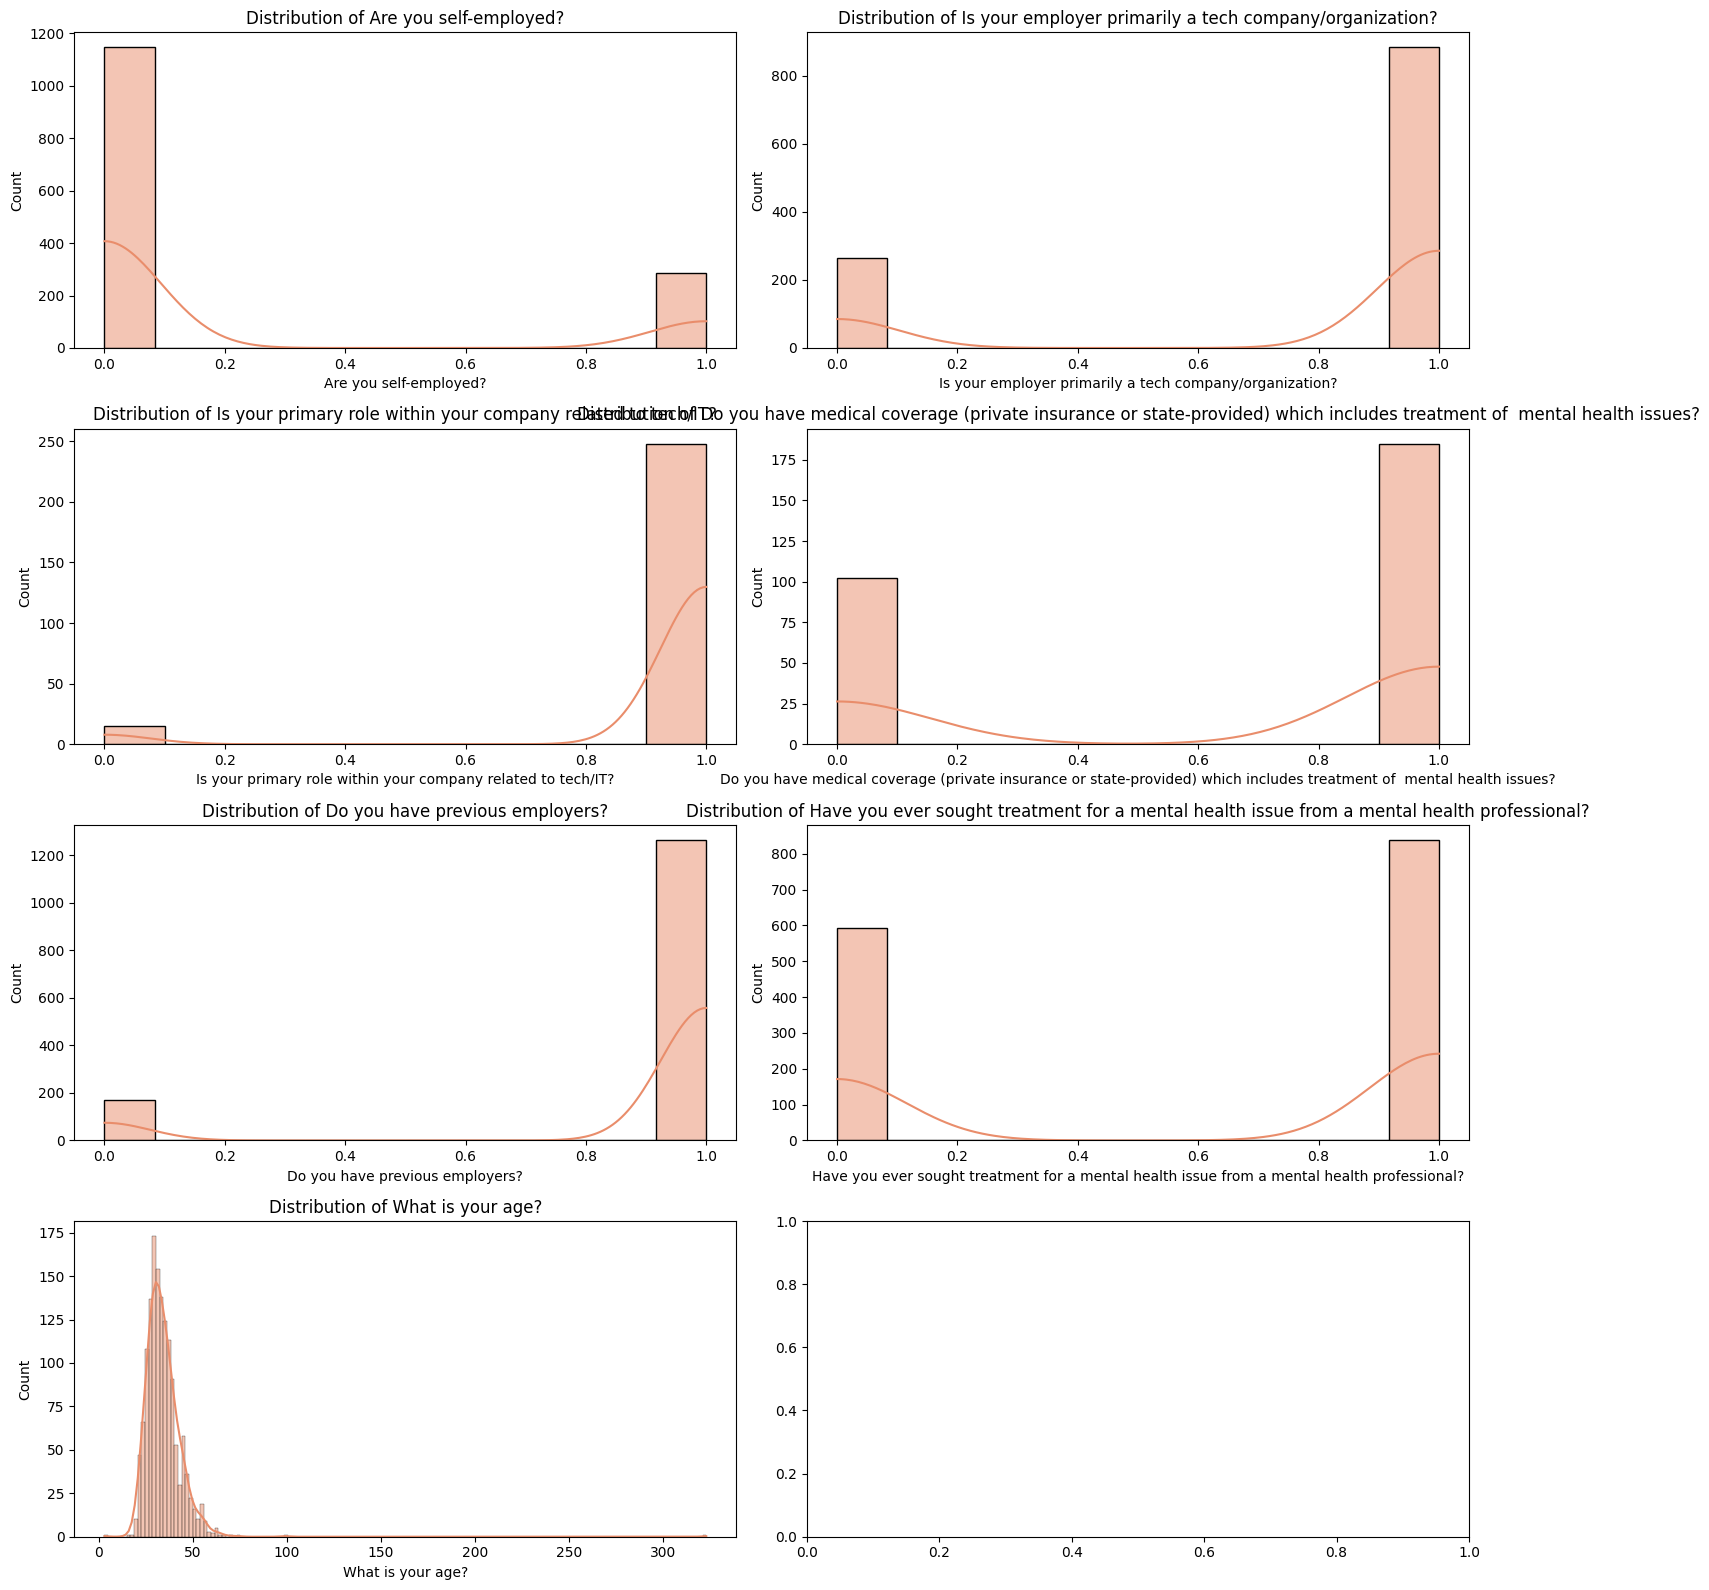

In [9]:
sns.set_palette("flare") # easy for eyes :)

plt.figure(figsize=(12, 6))
missing_values = df.isnull().sum()
missing_values.plot(kind='bar')
plt.title('Missing Values in Dataset')
plt.xlabel('Features')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Numerical values distribution visualization
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(nrows=(len(numerical_cols)+1)//2, ncols=2, figsize=(15, 4*((len(numerical_cols)+1)//2)))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [10]:
df.describe()

Are you self-employed?  \
count             1433.000000   
mean                 0.200279   
std                  0.400349   
min                  0.000000   
25%                  0.000000   
50%                  0.000000   
75%                  0.000000   
max                  1.000000   

       Is your employer primarily a tech company/organization?  \
count                                        1146.000000         
mean                                            0.770506         
std                                             0.420691         
min                                             0.000000         
25%                                             1.000000         
50%                                             1.000000         
75%                                             1.000000         
max                                             1.000000         

       Is your primary role within your company related to tech/IT?  \
count                                         263.000000              
mean                                            0.942966              
std                                             0.232350              
min                                             0.000000              
25%                                             1.000000              
50%                                             1.000000              
75%                                             1.000000              
max                                             1.000000              

       Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?  \
count                                         287.000000                                                                       
mean                                            0.644599                                                                       
std                                             0.479471                                                                       
min                                             0.000000                                                                       
25%                                             0.000000                                                                       
50%                                             1.000000                                                                       
75%                                             1.000000                                                                       
max                                             1.000000                                                                       

       Do you have previous employers?  \
count                      1433.000000   
mean                          0.882066   
std                           0.322643   
min                           0.000000   
25%                           1.000000   
50%                           1.000000   
75%                           1.000000   
max                           1.000000   

       Have you ever sought treatment for a mental health issue from a mental health professional?  \
count                                        1433.000000                                             
mean                                            0.585485                                             
std                                             0.492810                                             
min                                             0.000000                                             
25%                                             0.000000                                             
50%                                             1.000000                                             
75%                                             1.000000                                             
max                                             1.000000                                             

       What is your age

In [11]:
df['What is your age?'].sort_values(ascending=False) # 75 is the optimal value for sorting

564     323
372      99
1117     74
1221     70
701      66
       ... 
76       19
736      19
93       17
808      15
656       3
Name: What is your age?, Length: 1433, dtype: int64

In [12]:
df_cleaned = df[(df['What is your age?'] >= 18) & (df['What is your age?'] <= 75)]

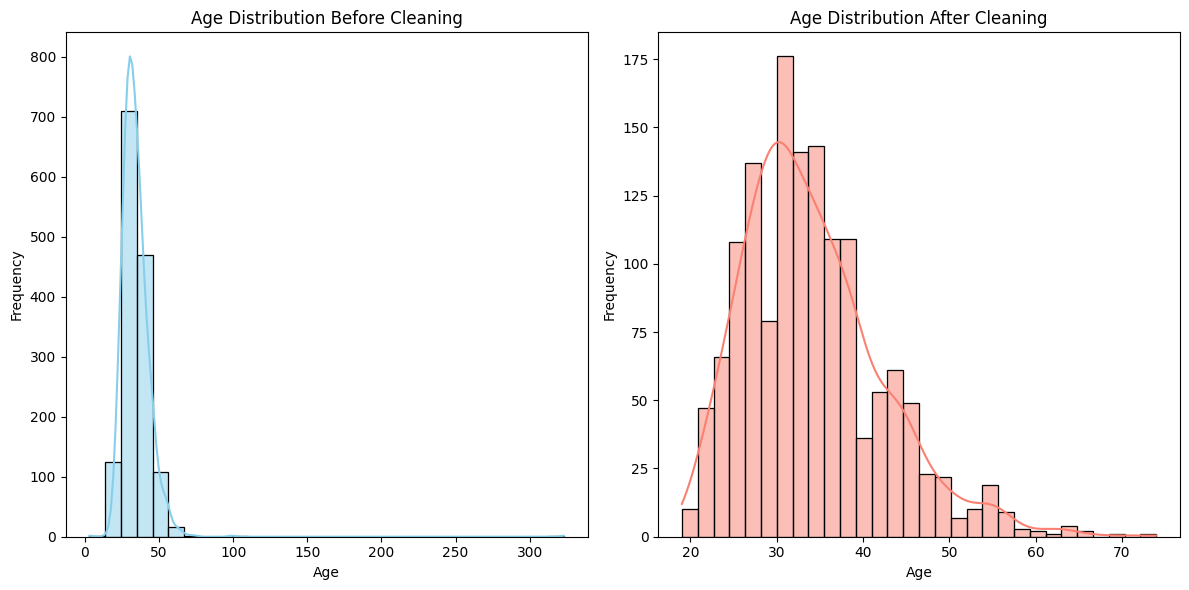

In [13]:
plt.figure(figsize=(12, 6))

# Before cleaning
plt.subplot(1, 2, 1)
sns.histplot(df['What is your age?'], bins=30, color='skyblue', kde=True, edgecolor='black')
plt.title('Age Distribution Before Cleaning')
plt.xlabel('Age')
plt.ylabel('Frequency')

# After cleaning
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['What is your age?'], bins=30, color='salmon', kde=True, edgecolor='black')
plt.title('Age Distribution After Cleaning')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [14]:
df['What is your age?'] = df_cleaned['What is your age?']

In [15]:
for column in df.columns:
    print(f"Column: {column}  \nMissing Value: {df[column].isnull().sum()}\n___________________________________________")

Column: Are you self-employed?  
Missing Value: 0
___________________________________________
Column: How many employees does your company or organization have?  
Missing Value: 287
___________________________________________
Column: Is your employer primarily a tech company/organization?  
Missing Value: 287
___________________________________________
Column: Is your primary role within your company related to tech/IT?  
Missing Value: 1170
___________________________________________
Column: Does your employer provide mental health benefits as part of healthcare coverage?  
Missing Value: 287
___________________________________________
Column: Do you know the options for mental health care available under your employer-provided coverage?  
Missing Value: 420
___________________________________________
Column: Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  
Missing Value: 287
______________________

In [16]:
df_copy = df.copy() # copy of df we will be continiuing with

# Calculate the percentage of missing values for each column
missing_percentage = df_copy.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 30].index.tolist() # more than 30 percent missing value col list

print(f"These are columns with more than 30% missing values and will be dropped:\nTotal Columns to be dropped: {len(columns_to_drop)}\n__________________________________")
for col in columns_to_drop:
    print(col)

# # Dropping these columns from the copied DataFrame
df_copy.drop(columns=columns_to_drop, inplace=True, axis=1)

These are columns with more than 30% missing values and will be dropped:
Total Columns to be dropped: 15
__________________________________
Is your primary role within your company related to tech/IT?
Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
Do you know local or online resources to seek help for a mental health disorder?
If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
Do you believe your productivity is ever affected by a mental health issue?
If yes, what percentage of your work

In [17]:
df_copy.drop(columns=['Why or why not?', 'Why or why not?.1'], inplace=True, axis=1)

In [18]:
df_copy.isnull().sum()

Are you self-employed?                                                                                                                              0
How many employees does your company or organization have?                                                                                        287
Is your employer primarily a tech company/organization?                                                                                           287
Does your employer provide mental health benefits as part of healthcare coverage?                                                                 287
Do you know the options for mental health care available under your employer-provided coverage?                                                   420
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?            287
Does your employer offer resources to learn more about mental health concerns and options for seekin

In [19]:
df_copy.nunique() # checking for unique values in colums

Are you self-employed?                                                                                                                              2
How many employees does your company or organization have?                                                                                          6
Is your employer primarily a tech company/organization?                                                                                             2
Does your employer provide mental health benefits as part of healthcare coverage?                                                                   4
Do you know the options for mental health care available under your employer-provided coverage?                                                     3
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?              3
Does your employer offer resources to learn more about mental health concerns and options for seekin

In [20]:
df_copy['What is your age?'].isnull().sum()

np.int64(5)

In [21]:
median_age = df_copy['What is your age?'].median()
median_age 

np.float64(33.0)

In [22]:
df_copy.fillna({'What is your age?': median_age}, inplace=True) # replacing 5 missing values with median

In [23]:
bins = [18, 26, 36, 46, 61, 75]  # Age ranges
labels = ['18-25', '26-35', '36-45', '46-60', '60+']

df_copy['Age Group'] = pd.cut(df_copy['What is your age?'].fillna(median_age), bins=bins, labels=labels, right=False)
df_copy['Age Group'] = df_copy['Age Group'].astype(str) # separating it from the Age column


# View results
df_copy[['What is your age?', 'Age Group']].head(10)

What is your age? Age Group
0               39.0     36-45
1               29.0     26-35
2               38.0     36-45
3               43.0     36-45
4               43.0     36-45
5               42.0     36-45
6               30.0     26-35
7               37.0     36-45
8               44.0     36-45
9               30.0     26-35

In [24]:
df_copy['What is your gender?'].unique()

array(['Male', 'male', 'Male ', 'Female', 'M', 'female', 'm',
       'I identify as female.', 'female ', 'Bigender', 'non-binary',
       'Female assigned at birth ', 'F', 'Woman', 'man', 'fm', 'f',
       'Cis female ', 'Transitioned, M2F', 'Genderfluid (born female)',
       'Other/Transfeminine', 'Female or Multi-Gender Femme', 'Female ',
       'woman', 'female/woman', 'Cis male', 'Male.', 'Androgynous',
       'male 9:1 female, roughly', nan, 'Male (cis)', 'Other',
       'nb masculine', 'Cisgender Female', 'Man', 'Sex is male',
       'none of your business', 'genderqueer', 'cis male', 'Human',
       'Genderfluid', 'Enby', 'Malr', 'genderqueer woman', 'mtf', 'Queer',
       'Agender', 'Dude', 'Fluid',
       "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
       'mail', 'M|', 'Male/genderqueer', 'fem', 'Nonbinary', 'male ',
       'human', 'Female (props for making th

In [25]:
gender_map = {}

male = ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 
        'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male', 
        'cis male', 'Malr', 'Dude', 'mail', 'M|', 'male ', 'Cis Male',
        'cisdude', 'cis man', 'MALE', 'Male/genderqueer', 'Male (trans, FtM)',
        "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? "]

female = ['Female', 'I identify as female.', 'female ', 'Female assigned at birth ', 
          'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F', 
          'Genderfluid (born female)', 'Female or Multi-Gender Femme', 'Female ', 
          'woman', 'female/woman', 'Cisgender Female', 'mtf', 'fem', 
          'Female (props for making this a freeform field, though)', ' Female', 
          'Cis-woman', 'AFAB', 'female']

other = ['Bigender', 'non-binary', 'Other/Transfeminine', 'Androgynous', 
         'Other', 'nb masculine', 'none of your business', 'genderqueer', 'Human',
         'Genderfluid', 'Enby', 'genderqueer woman', 'Queer', 'Agender', 'Fluid', 
         'Nonbinary', 'Unicorn', 'Genderqueer', 'Genderflux demi-girl',
         'female-bodied; no feelings about gender', 'Transgender woman', 'human']

gender_map.update({key: 'Male' for key in male})
gender_map.update({key: 'Female' for key in female})
gender_map.update({key: 'Other' for key in other})

In [26]:
df_copy['What is your gender?'] = df_copy['What is your gender?'].map(gender_map)
df_copy['What is your gender?'].value_counts()

What is your gender?
Male      1060
Female     343
Other       27
Name: count, dtype: int64

In [27]:
df_copy['What is your gender?'] = df_copy['What is your gender?'].apply(lambda x: 0 if x == 'Male' else (1 if x == 'Female' else 2))

In [28]:
df_copy['What is your gender?'].value_counts()

What is your gender?
0    1060
1     343
2      30
Name: count, dtype: int64

In [29]:
df_copy['Which of the following best describes your work position?'].unique()

array(['Back-end Developer', 'Back-end Developer|Front-end Developer',
       'Supervisor/Team Lead',
       'Executive Leadership|Supervisor/Team Lead|Dev Evangelist/Advocate|DevOps/SysAdmin|Support|Back-end Developer|Front-end Developer',
       'DevOps/SysAdmin|Support|Back-end Developer|Front-end Developer|Designer',
       'Dev Evangelist/Advocate|Back-end Developer',
       'Support|Back-end Developer|One-person shop',
       'One-person shop|Front-end Developer|Back-end Developer',
       'Front-end Developer', 'Executive Leadership',
       'Supervisor/Team Lead|Dev Evangelist/Advocate|Back-end Developer|Front-end Developer',
       'DevOps/SysAdmin|Back-end Developer|Front-end Developer',
       'Designer', 'Other|Executive Leadership', 'One-person shop',
       'Other', 'Supervisor/Team Lead|Support|Back-end Developer',
       'Supervisor/Team Lead|DevOps/SysAdmin|Back-end Developer',
       'Other|Supervisor/Team Lead|Support|Back-end Developer|Designer',
       'Supervisor/

In [30]:
def categorize_role(role_string):
    
    developer_roles = {'Front-end Developer', 'Back-end Developer', 'DevOps/SysAdmin'}
    leadership_roles = {'Executive Leadership', 'Supervisor/Team Lead'}
    support_roles = {'Support', 'Dev Evangelist/Advocate'}
    sales_and_hr = {'HR', 'Sales'}
    design_roles = {'Designer'}
    other_roles = {'Other', 'One-person shop' }
    
    roles = set(role_string.split('|')) # splitting the roles
    
    # Check predominant category (for the count pupose below)
    dev_count = len(roles.intersection(developer_roles))
    lead_count = len(roles.intersection(leadership_roles))
    support_count = len(roles.intersection(support_roles))
    design_count = len(roles.intersection(design_roles))
    sales_and_hr = len(roles.intersection(sales_and_hr))
    other_count = len(roles.intersection(other_roles))
    
    counts = {
        'Developer': dev_count,
        'Leadership': lead_count,
        'Support': support_count,
        'Design': design_count,
        'Sales & HR': sales_and_hr,
        'Other': other_count
    }
    
    max_category = max(counts.items(), key=lambda x: x[1])
    
    # If there's no clear category (all counts are 0), return 'Other' - I guess this is pretty safe to consider other?
    if max_category[1] == 0:
        return 'Other'
    
    # If there's a tie with Leadership, prioritize Leadership
    if lead_count > 0 and lead_count >= max(dev_count, support_count, design_count, other_count):
        return 'Leadership'
    
    return max_category[0]



In [31]:
df_copy['Which of the following best describes your work position?'] = df_copy['Which of the following best describes your work position?'].apply(categorize_role)

In [32]:
df_copy['Which of the following best describes your work position?'].value_counts()

Which of the following best describes your work position?
Developer     916
Leadership    225
Other         171
Support        79
Design         31
Sales & HR     11
Name: count, dtype: int64

In [33]:
df_copy['What country do you live in?'].unique()

array(['United Kingdom', 'United States of America', 'Canada', 'Germany',
       'Netherlands', 'Czech Republic', 'Lithuania', 'Australia',
       'France', 'Venezuela', 'Poland', 'Belgium', 'Brazil', 'Denmark',
       'Sweden', 'Russia', 'Spain', 'India', 'Mexico', 'Switzerland',
       'Norway', 'Argentina', 'Ireland', 'Italy', 'Finland', 'Colombia',
       'Costa Rica', 'Vietnam', 'Bulgaria', 'New Zealand', 'South Africa',
       'Slovakia', 'Austria', 'Bangladesh', 'Algeria', 'Pakistan',
       'Afghanistan', 'Greece', 'Romania', 'Other', 'Brunei', 'Japan',
       'Iran', 'Hungary', 'Israel', 'Ecuador', 'Bosnia and Herzegovina',
       'China', 'Chile', 'Guatemala', 'Taiwan', 'Serbia', 'Estonia'],
      dtype=object)

In [34]:
live = df_copy['What country do you live in?'].to_list()
work = df_copy['What country do you work in?'].to_list()

In [35]:
for country in work:
    if country not in live:
        print(country) # to check which one differs from the list

United Arab Emirates
Turkey


In [36]:
def categorize_country(country):
    
    north_america = {'United States of America', 'Canada', 'Mexico', 'Costa Rica', 'Guatemala'}
    
    europe = {'United Kingdom', 'Germany', 'Netherlands', 'Czech Republic', 'Lithuania',
              'France', 'Poland', 'Belgium', 'Denmark', 'Sweden', 'Russia', 'Spain',
              'Switzerland', 'Norway', 'Ireland', 'Italy', 'Finland', 'Bulgaria',
              'Slovakia', 'Austria', 'Greece', 'Romania', 'Hungary', 'Bosnia and Herzegovina',
              'Serbia', 'Estonia'}
    
    asia = {'India', 'Vietnam', 'Bangladesh', 'Pakistan', 'Afghanistan', 'Brunei', 
            'Japan', 'China', 'Taiwan'}

    middle_east = {'United Arab Emirates', 'Iran', 'Israel', 'Turkey'}
    
    south_america = {'Venezuela', 'Brazil', 'Argentina', 'Colombia', 'Ecuador', 'Chile'}
    
    oceania = {'Australia', 'New Zealand'}
    
    africa = {'South Africa', 'Algeria'}
    
    # Check which region the country belongs to
    if country in north_america:
        return 'North America'
    elif country in europe:
        return 'Europe'
    elif country in asia:
        return 'Asia'
    elif country in middle_east:
        return 'Middle East'
    elif country in south_america:
        return 'South America'
    elif country in oceania:
        return 'Oceania'
    elif country in africa:
        return 'Africa'
    else:
        return 'Other'

In [37]:
df_copy['What country do you live in?'] = df_copy['What country do you live in?'].apply(categorize_country)
df_copy['What country do you work in?'] = df_copy['What country do you work in?'].apply(categorize_country)

In [38]:
df_copy['What country do you live in?'].value_counts()

What country do you live in?
North America    922
Europe           418
Oceania           44
Asia              21
South America     18
Africa             5
Middle East        3
Other              2
Name: count, dtype: int64

In [39]:
df_copy['What country do you work in?'].value_counts()

What country do you work in?
North America    929
Europe           414
Oceania           43
South America     18
Asia              18
Middle East        5
Africa             4
Other              2
Name: count, dtype: int64

In [40]:
df_copy.head() # checking for values in colums

Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                NaN                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                NaN                                                
1                                                Yes                                                
2                                                NaN                                                
3                                                NaN                                                
4                                                Yes                                                

  Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                 No                                                                                       
1                                                Yes                                                                                       
2                                                 No                                                                                       
3                                                NaN                                                                                       
4                                                 No                                                                                       

  Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                 No                                                            
1                                                Yes                                                            
2                                                 No                                                            
3                                                NaN                                                            
4                                                 No                                                            

  Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
0                                       I don't know                                                                                               
1                                                Yes                                                                        

In [41]:
df_copy.describe()

Are you self-employed?  \
count             1433.000000   
mean                 0.200279   
std                  0.400349   
min                  0.000000   
25%                  0.000000   
50%                  0.000000   
75%                  0.000000   
max                  1.000000   

       Is your employer primarily a tech company/organization?  \
count                                        1146.000000         
mean                                            0.770506         
std                                             0.420691         
min                                             0.000000         
25%                                             1.000000         
50%                                             1.000000         
75%                                             1.000000         
max                                             1.000000         

       Do you have previous employers?  \
count                      1433.000000   
mean                          0.882066   
std                           0.322643   
min                           0.000000   
25%                           1.000000   
50%                           1.000000   
75%                           1.000000   
max                           1.000000   

       Have you ever sought treatment for a mental health issue from a mental health professional?  \
count                                        1433.000000                                             
mean                                            0.585485                                             
std                                             0.492810                                             
min                                             0.000000                                             
25%                                             0.000000                                             
50%                                             1.000000                                             
75%                                             1.000000                                             
max                                             1.000000                                             

       What is your age?  What is your gender?  
count        1433.000000           1433.000000  
mean           34.082345              0.281228  
std             8.072398              0.494145  
min            19.000000              0.000000  
25%            28.000000              0.000000  
50%            33.000000              0.000000  
75%            38.000000              1.000000  
max            74.000000              2.000000

In [42]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 47 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                          --------------  -----  
 0   Are you self-employed?                                                                                                                          1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                      1146 non-null   object 
 2   Is your employer primarily a tech company/organization?                                                                                         1146 non-null   float64
 3   Does your employer prov

In [43]:
def map_responses(column):
    unique_vals = column.unique()
    unique_vals = unique_vals[~pd.isna(unique_vals)]  # Remove NaN from unique values
    if set(unique_vals) == {'Yes', 'No'}:
        mapping = {'Yes': 1, 'No': 0}
    elif set(unique_vals) == {'Yes', 'No', "I don't know"}:
        mapping = {'Yes': 1, 'No': 0, "I don't know": 2}
    elif set(unique_vals) == {'Yes', 'No', 'Maybe'}:
        mapping = {'Yes': 1, 'No': 0, 'Maybe': 2}
    else:
        # Return the original values if they don't match any of the specified sets
        return column

    return column.map(mapping)

In [44]:
for col in df_copy:
    df_copy[col] = map_responses(df_copy[col])
    

In [45]:
categorical = [column for column in df_copy.columns if df_copy[column].dtype == 'object']
numerical = [column for column in df_copy.columns if df_copy[column].dtype != 'object']

In [46]:
df_copy[numerical].isnull().sum()

Are you self-employed?                                                                                                                              0
Is your employer primarily a tech company/organization?                                                                                           287
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?            287
Does your employer offer resources to learn more about mental health concerns and options for seeking help?                                       287
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?    287
Do you think that discussing a mental health disorder with your employer would have negative consequences?                                        287
Do you think that discussing a physical health issue with your employer would have negative conseque

In [47]:
# fit regression model using Bayesian Ridge since this numerical and floats are continuous so we will use regression
imputer = IterativeImputer(estimator=lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, verbose=-1), random_state=1, verbose=0)

imputed_data = imputer.fit_transform(df_copy[numerical])

# substitute imputed values for missing values
df_imputed_numerical = pd.DataFrame(imputed_data, columns=df_copy[numerical].columns, 
                                    index=df_copy[numerical].index) # retaining index for merging later with categorical one


C:\Users\bugra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\bugra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\bugra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\bugra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\bugra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserW

In [48]:
df_imputed_numerical.head()

Are you self-employed?  \
0                     0.0   
1                     0.0   
2                     0.0   
3                     1.0   
4                     0.0   

   Is your employer primarily a tech company/organization?  \
0                                           1.000000         
1                                           1.000000         
2                                           1.000000         
3                                           0.712523         
4                                           0.000000         

   Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                           0.000000                                                                                        
1                                           1.000000                                                                                        
2                                           0.000000                                                                                        
3                                           0.994506                                                                                        
4                                           0.000000                                                                                        

   Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                           0.000000                                                             
1                                           1.000000                                                             
2                                           0.000000                                                             
3                                           0.811201                                                             
4                                           0.000000                                                             

   Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
0                                           2.000000                                                                                                
1                                           1.000000                                                                                                
2                                           2.000000                                                                                                
3                                           1.176808                                                                                                
4                                           0.000000                                                                                                

   Do you think that discussing a mental health disorder with your employer would have negative consequences?  \
0                                           0.000000                                                            
1                                           0.000000                                                            
2                                           2.000000                                                            
3                                           0.387416                                                            
4                                           1.000000                                                            

   Do you think that discussing a physical health issue with your employer would have negative consequences?  \
0                                           0.000000                                                           
1                                           0.000000                                                           
2            

In [49]:
df_imputed_numerical['Is your employer primarily a tech company/organization?'].unique()

array([1.        , 0.71252251, 0.        , 0.83726632, 0.74150537,
       0.77143304, 0.81084721, 0.67942221, 0.86838883, 0.80924192,
       0.790731  , 0.79529819, 0.82008349, 0.87498659, 0.77156346,
       0.79114548, 0.70584059, 0.84937552, 0.76245579, 0.75267848,
       0.7484821 , 0.77878966, 0.81646393, 0.61371415, 0.72891547,
       0.7803248 , 0.66666509, 0.29106236, 0.86703988, 0.85477504,
       0.77171024, 0.49261326, 0.73801251, 0.6998336 , 0.77906527,
       0.51705062, 0.84731281, 0.70627677, 0.81854875, 0.72059674,
       0.63559343, 0.86449217, 0.7621901 , 0.75754072, 0.74320409,
       0.7589437 , 0.71687676, 0.45575373, 0.49737874, 0.65444964,
       0.70768883, 0.7976472 , 0.76753876, 0.67071145, 0.86924988,
       0.67868769, 0.66225411, 0.82771064, 0.72072048, 0.79206036,
       0.7324902 , 0.80857591, 0.64338873, 0.81323826, 0.8105524 ,
       0.78059778, 0.75052555, 0.69611492, 0.75801107, 0.7942992 ,
       0.75192712, 0.79337886, 0.38169487, 0.86608337, 0.65816

In [50]:
df_imputed_numerical = df_imputed_numerical.round().astype(int)

In [51]:
df_imputed_numerical.describe()

Are you self-employed?  \
count             1433.000000   
mean                 0.200279   
std                  0.400349   
min                  0.000000   
25%                  0.000000   
50%                  0.000000   
75%                  0.000000   
max                  1.000000   

       Is your employer primarily a tech company/organization?  \
count                                        1433.000000         
mean                                            0.798325         
std                                             0.401391         
min                                             0.000000         
25%                                             1.000000         
50%                                             1.000000         
75%                                             1.000000         
max                                             1.000000         

       Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
count                                        1433.000000                                                                                        
mean                                            0.504536                                                                                        
std                                             0.627701                                                                                        
min                                             0.000000                                                                                        
25%                                             0.000000                                                                                        
50%                                             0.000000                                                                                        
75%                                             1.000000                                                                                        
max                                             2.000000                                                                                        

       Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
count                                        1433.000000                                                             
mean                                            0.817167                                                             
std                                             0.772293                                                             
min                                             0.000000                                                             
25%                                             0.000000                                                             
50%                                             1.000000                                                             
75%                                             1.000000                                                             
max                                             2.000000                                                             

       Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
count                                        1433.000000                                                                                                
mean                                            1.459177                                                                                                
std                                             0.604835                                                                                                
min                                             0.000000                                                                             

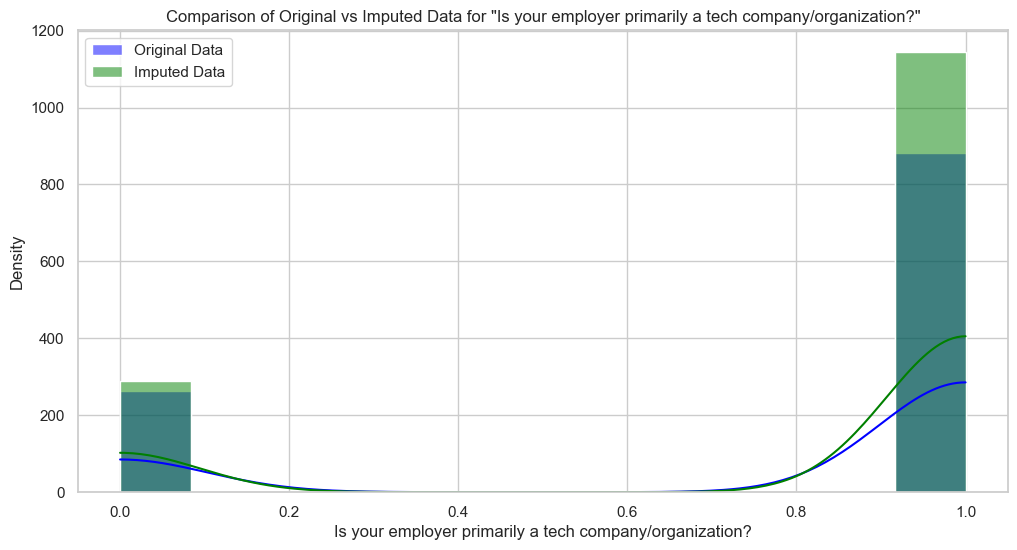

In [52]:
# comparing imputed data for one column 
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(pd.to_numeric(df_copy['Is your employer primarily a tech company/organization?']).astype('Int64'), kde=True, color='blue', label='Original Data', fill=True, alpha=0.5)
sns.histplot(df_imputed_numerical['Is your employer primarily a tech company/organization?'], color='green', kde=True, label='Imputed Data', fill=True, alpha=0.5)

plt.title('Comparison of Original vs Imputed Data for "Is your employer primarily a tech company/organization?"')
plt.xlabel('Is your employer primarily a tech company/organization?')
plt.ylabel('Density')
plt.legend()
plt.show()


In [53]:
df_imputed_numerical.isnull().sum()

Are you self-employed?                                                                                                                            0
Is your employer primarily a tech company/organization?                                                                                           0
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?            0
Does your employer offer resources to learn more about mental health concerns and options for seeking help?                                       0
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?    0
Do you think that discussing a mental health disorder with your employer would have negative consequences?                                        0
Do you think that discussing a physical health issue with your employer would have negative consequences?       

In [54]:
df_copy[numerical] = df_imputed_numerical # assigning it back to df_copy

In [55]:
df_copy[categorical].head()

How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                NaN                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                NaN                                                
1                                                Yes                                                
2                                                NaN                                                
3                                                NaN                                                
4                                                Yes                                                

  If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:  \
0                                          Very easy                                                            
1                                      Somewhat easy                                                            
2                         Neither easy nor difficult                                                            
3                                                NaN                                                            
4                         Neither easy nor difficult                                                            

  Have your previous employers provided mental health benefits?  \
0                                       No, none did              
1                                  Yes, they all did              
2                                       No, none did              
3                                           Some did              
4                                       I don't know              

  Were you aware of the options for mental health care provided by your previous employers?  \
0                          N/A (not currently aware)                                          
1                                I was aware of some                                          
2                          N/A (not currently aware)                                          
3                          N/A (not currently aware)                                          
4                          N/A (not currently aware)                                          

  Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?  \
0                                       I don't know                                                                                  
1                                           None did                                                                                  
2                                           None did                                                                                  
3                                           None did                                                                                  
4                                           Some did                                                                                  

  Did your previous emp

In [56]:
df_copy[categorical].isnull().sum()

How many employees does your company or organization have?                                                                                      287
Does your employer provide mental health benefits as part of healthcare coverage?                                                               287
Do you know the options for mental health care available under your employer-provided coverage?                                                 420
If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:                                     287
Have your previous employers provided mental health benefits?                                                                                   169
Were you aware of the options for mental health care provided by your previous employers?                                                       169
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other officia

In [57]:
def label_encode_df(df_to_encode):
    label_encoders = {}

    df_encoded = df_to_encode.copy()
    
    for col in df_encoded.columns:
        le = LabelEncoder()
        # Temporarily drop NaN for encoding, then add them back
        non_nan_values = df_encoded[col].dropna().unique()
        le.fit(non_nan_values)  # Fit only on non-NaN values
        label_encoders[col] = le  # Save encoder
        
        df_encoded[col] = df_encoded[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
    return df_encoded, label_encoders

In [58]:
def impute_categorical_data(df_encoded, label_encoders):

    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns, index=df_encoded.index)
    
    # Decode the imputed values back to original categories
    for col in df_imputed.columns:
        df_imputed[col] = df_imputed[col].round().astype(int)
        df_imputed[col] = df_imputed[col].apply(lambda x: label_encoders[col].inverse_transform([x])[0])
    
    df_copy_imputed = df_copy.copy()  
    df_copy_imputed[categorical] = df_imputed

    return df_copy_imputed

In [59]:
encoded_df, label_encoders = label_encode_df(df_copy[categorical])
df_imputed = impute_categorical_data(encoded_df, label_encoders)

In [60]:
df_imputed[categorical].describe()

How many employees does your company or organization have?  \
count                                                1433           
unique                                                  6           
top                                                26-100           
freq                                                  374           

       Does your employer provide mental health benefits as part of healthcare coverage?  \
count                                                1433                                  
unique                                                  4                                  
top                                                   Yes                                  
freq                                                  549                                  

       Do you know the options for mental health care available under your employer-provided coverage?  \
count                                                1433                                                
unique                                                  3                                                
top                                                    No                                                
freq                                                  681                                                

       If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:  \
count                                                1433                                                            
unique                                                  6                                                            
top                                         Somewhat easy                                                            
freq                                                  411                                                            

       Have your previous employers provided mental health benefits?  \
count                                                1433              
unique                                                  4              
top                                          No, none did              
freq                                                  483              

       Were you aware of the options for mental health care provided by your previous employers?  \
count                                                1433                                          
unique                                                  4                                          
top                             N/A (not currently aware)                                          
freq                                                  724                                          

       Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?  \
count                                                1433                                                                                  
unique                                                  4                                                                                  
top                                              None did                                                                                  
freq                                                 1049                                                                                  

       Did your previous employers provide resources to learn more about mental health issues and how to seek help?  \
count                                                1433                                                             
unique                                                  3                                                             
top                                              None did                                                             
freq                                   

In [61]:
df_imputed.isnull().sum()

Are you self-employed?                                                                                                                            0
How many employees does your company or organization have?                                                                                        0
Is your employer primarily a tech company/organization?                                                                                           0
Does your employer provide mental health benefits as part of healthcare coverage?                                                                 0
Do you know the options for mental health care available under your employer-provided coverage?                                                   0
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?            0
Does your employer offer resources to learn more about mental health concerns and options for seeking help?     

In [62]:
df_imputed.head()

Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                           500-1000           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                  1         
1                                                  1         
2                                                  1         
3                                                  1         
4                                                  0         

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                 No                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                 No                                                
1                                                Yes                                                
2                                                 No                                                
3                                      I am not sure                                                
4                                                Yes                                                

   Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                  0                                                                                        
1                                                  1                                                                                        
2                                                  0                                                                                        
3                                                  1                                                                                        
4                                                  0                                                                                        

   Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                  0                                                             
1                                                  1                                                             
2                                                  0                                                             
3                                                  1                                                             
4                                                  0                                                             

   Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
0                                                  2                                                                                                
1                                                  1                                                          

In [63]:
for col in df_imputed[categorical]: # verifying unique values
    print(df_imputed[col].unique())

['26-100' '6-25' '500-1000' 'More than 1000' '100-500' '1-5']
['Not eligible for coverage / N/A' 'No' 'Yes' "I don't know"]
['No' 'Yes' 'I am not sure']
['Very easy' 'Somewhat easy' 'Neither easy nor difficult'
 'Somewhat difficult' 'Very difficult' "I don't know"]
['No, none did' 'Yes, they all did' 'Some did' "I don't know"]
['N/A (not currently aware)' 'I was aware of some'
 'Yes, I was aware of all of them' 'No, I only became aware later']
["I don't know" 'None did' 'Some did' 'Yes, they all did']
['None did' 'Some did' 'Yes, they all did']
["I don't know" 'Yes, always' 'Sometimes' 'No']
['Some of them' 'None of them' "I don't know" 'Yes, all of them']
['None of them' 'Some of them' 'Yes, all of them']
['Some of my previous employers' 'No, at none of my previous employers'
 'Yes, at all of my previous employers']
['Some of my previous employers' "I don't know"
 'No, at none of my previous employers'
 'Yes, at all of my previous employers']
["I don't know" 'Some did' 'None did' 'Yes

In [64]:
df_cluster = df_imputed.copy() # for later use for clustering
df_cluster.drop(columns='What country do you work in?', inplace=True)
# we dropped the column later on so we are dropping it here as well, scroll down to corr matrix for reference

In [65]:
scaler = StandardScaler()
df_imputed[numerical] = scaler.fit_transform(df_imputed[numerical])

In [66]:
df_imputed.head()

Are you self-employed?  \
0               -0.500436   
1               -0.500436   
2               -0.500436   
3                1.998257   
4               -0.500436   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                           500-1000           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                           0.502616         
1                                           0.502616         
2                                           0.502616         
3                                           0.502616         
4                                          -1.989592         

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                 No                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                 No                                                
1                                                Yes                                                
2                                                 No                                                
3                                      I am not sure                                                
4                                                Yes                                                

   Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                          -0.804064                                                                                        
1                                           0.789607                                                                                        
2                                          -0.804064                                                                                        
3                                           0.789607                                                                                        
4                                          -0.804064                                                                                        

   Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                          -1.058474                                                             
1                                           0.236823                                                             
2                                          -1.058474                                                             
3                                           0.236823                                                             
4                                          -1.058474                                                             

   Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
0                                           0.894479                                                                                                
1                                          -0.759442                                                          

In [67]:
df_imputed.columns

Index(['Are you self-employed?',
       'How many employees does your company or organization have?',
       'Is your employer primarily a tech company/organization?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Do you know the options for mental health care available under your employer-provided coverage?',
       'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
       'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
       'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
       'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
       'Do you think that discussing a mental health disorder with your employer would have negative

In [68]:
column_rename_mapping = {
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'mh_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'mh_options_awareness',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'mh_discussed',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'mh_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'mh_leave_request',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'mh_negative_employer',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'ph_negative_employer',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'mh_comfort_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'mh_comfort_supervisor',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'mh_vs_ph_importance',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'mh_neg_obs_current',
    'Do you have previous employers?': 'has_prev_employers',
    'Have your previous employers provided mental health benefits?': 'prev_mh_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'prev_mh_awareness',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_mh_discussed',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_mh_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity_protected',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_mh_negative',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_ph_negative',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_mh_comfort_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_mh_comfort_supervisor',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_mh_vs_ph',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_mh_neg_obs',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'ph_comfort_interview',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'mh_comfort_interview',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'mh_career_hurt',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'mh_negative_coworkers',
    'How willing would you be to share with friends and family that you have a mental illness?': 'mh_share_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'mh_bad_response_obs',
    'Do you have a family history of mental illness?': 'family_mh_history',
    'Have you had a mental health disorder in the past?': 'mh_disorder_past',
    'Do you currently have a mental health disorder?': 'mh_disorder_current',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'mh_diagnosed',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'mh_treatment_sought',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'mh_interferes_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'mh_interferes_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you live in?': 'country_residence',
    'What country do you work in?': 'country_work',
    'Which of the following best describes your work position?': 'work_position',
    'Do you work remotely?': 'remote_work',
    'Age Group': 'age_group'
}


In [69]:
df_imputed.rename(columns=column_rename_mapping, inplace=True)

In [70]:
df_imputed.head()

self_employed company_size  tech_company                      mh_benefits  \
0      -0.500436       26-100      0.502616  Not eligible for coverage / N/A   
1      -0.500436         6-25      0.502616                               No   
2      -0.500436         6-25      0.502616                               No   
3       1.998257     500-1000      0.502616                               No   
4      -0.500436         6-25     -1.989592                              Yes   

  mh_options_awareness  mh_discussed  mh_resources  anonymity_protected  \
0                   No     -0.804064     -1.058474             0.894479   
1                  Yes      0.789607      0.236823            -0.759442   
2                   No     -0.804064     -1.058474             0.894479   
3        I am not sure      0.789607      0.236823            -0.759442   
4                  Yes     -0.804064     -1.058474            -2.413363   

             mh_leave_request  mh_negative_employer  ...  mh_treatment_sought  \
0                   Very easy             -0.956971  ...            -1.188469   
1               Somewhat easy             -0.956971  ...             0.841419   
2  Neither easy nor difficult              1.274664  ...             0.841419   
3          Somewhat difficult             -0.956971  ...             0.841419   
4  Neither easy nor difficult              0.158846  ...             0.841419   

   mh_interferes_treated  mh_interferes_untreated       age    gender  \
0   Not applicable to me     Not applicable to me  0.609407 -0.569319   
1                 Rarely                Sometimes -0.629815 -0.569319   
2   Not applicable to me     Not applicable to me  0.485484 -0.569319   
3              Sometimes                Sometimes  1.105095 -0.569319   
4              Sometimes                Sometimes  1.105095  1.455084   

   country_residence   country_work work_position remote_work age_group  
0             Europe         Europe     Developer   Sometimes     36-45  
1      North America  North America     Developer       Never     26-35  
2             Europe         Europe     Developer      Always     36-45  
3             Europe         Europe    Leadership   Sometimes     36-45  
4      North America  North America     Developer   Sometimes     36-45  

[5 rows x 47 columns]

In [71]:
categorical_renamed = [column for column in df_imputed.columns if df_imputed[column].dtype == 'object']

In [72]:
ohe = OneHotEncoder(sparse_output=False)  # drop='first' avoids multicollinearity

ohe = pd.DataFrame(ohe.fit_transform(df_imputed[categorical_renamed]),
                            columns=ohe.get_feature_names_out(categorical_renamed))

# Drop original categorical columns and concatenate OHE features
df_imputed = pd.concat([df_imputed.drop(columns=categorical_renamed), ohe], axis=1)

In [73]:
df_imputed.head()

self_employed  tech_company  mh_discussed  mh_resources  \
0      -0.500436      0.502616     -0.804064     -1.058474   
1      -0.500436      0.502616      0.789607      0.236823   
2      -0.500436      0.502616     -0.804064     -1.058474   
3       1.998257      0.502616      0.789607      0.236823   
4      -0.500436     -1.989592     -0.804064     -1.058474   

   anonymity_protected  mh_negative_employer  ph_negative_employer  \
0             0.894479             -0.956971             -0.766550   
1            -0.759442             -0.956971             -0.766550   
2             0.894479              1.274664             -0.766550   
3            -0.759442             -0.956971              0.501887   
4            -2.413363              0.158846              1.770323   

   mh_comfort_coworkers  mh_comfort_supervisor  mh_vs_ph_importance  ...  \
0              1.168659              -0.045396             1.199484  ...   
1              1.168659              -0.045396            -0.023904  ...   
2              1.168659               1.368794             1.199484  ...   
3             -0.101006              -0.045396            -1.247293  ...   
4              1.168659              -1.459587            -1.247293  ...   

   work_position_Sales & HR  work_position_Support  remote_work_Always  \
0                       0.0                    0.0                 0.0   
1                       0.0                    0.0                 0.0   
2                       0.0                    0.0                 1.0   
3                       0.0                    0.0                 0.0   
4                       0.0                    0.0                 0.0   

   remote_work_Never  remote_work_Sometimes  age_group_18-25  age_group_26-35  \
0                0.0                    1.0              0.0              0.0   
1                1.0                    0.0              0.0              1.0   
2                0.0                    0.0              0.0              0.0   
3                0.0                    1.0              0.0              0.0   
4                0.0                    1.0              0.0              0.0   

   age_group_36-45  age_group_46-60  age_group_60+  
0              1.0              0.0            0.0  
1              0.0              0.0            0.0  
2              1.0              0.0            0.0  
3              1.0              0.0            0.0  
4              1.0              0.0            0.0  

[5 rows x 140 columns]

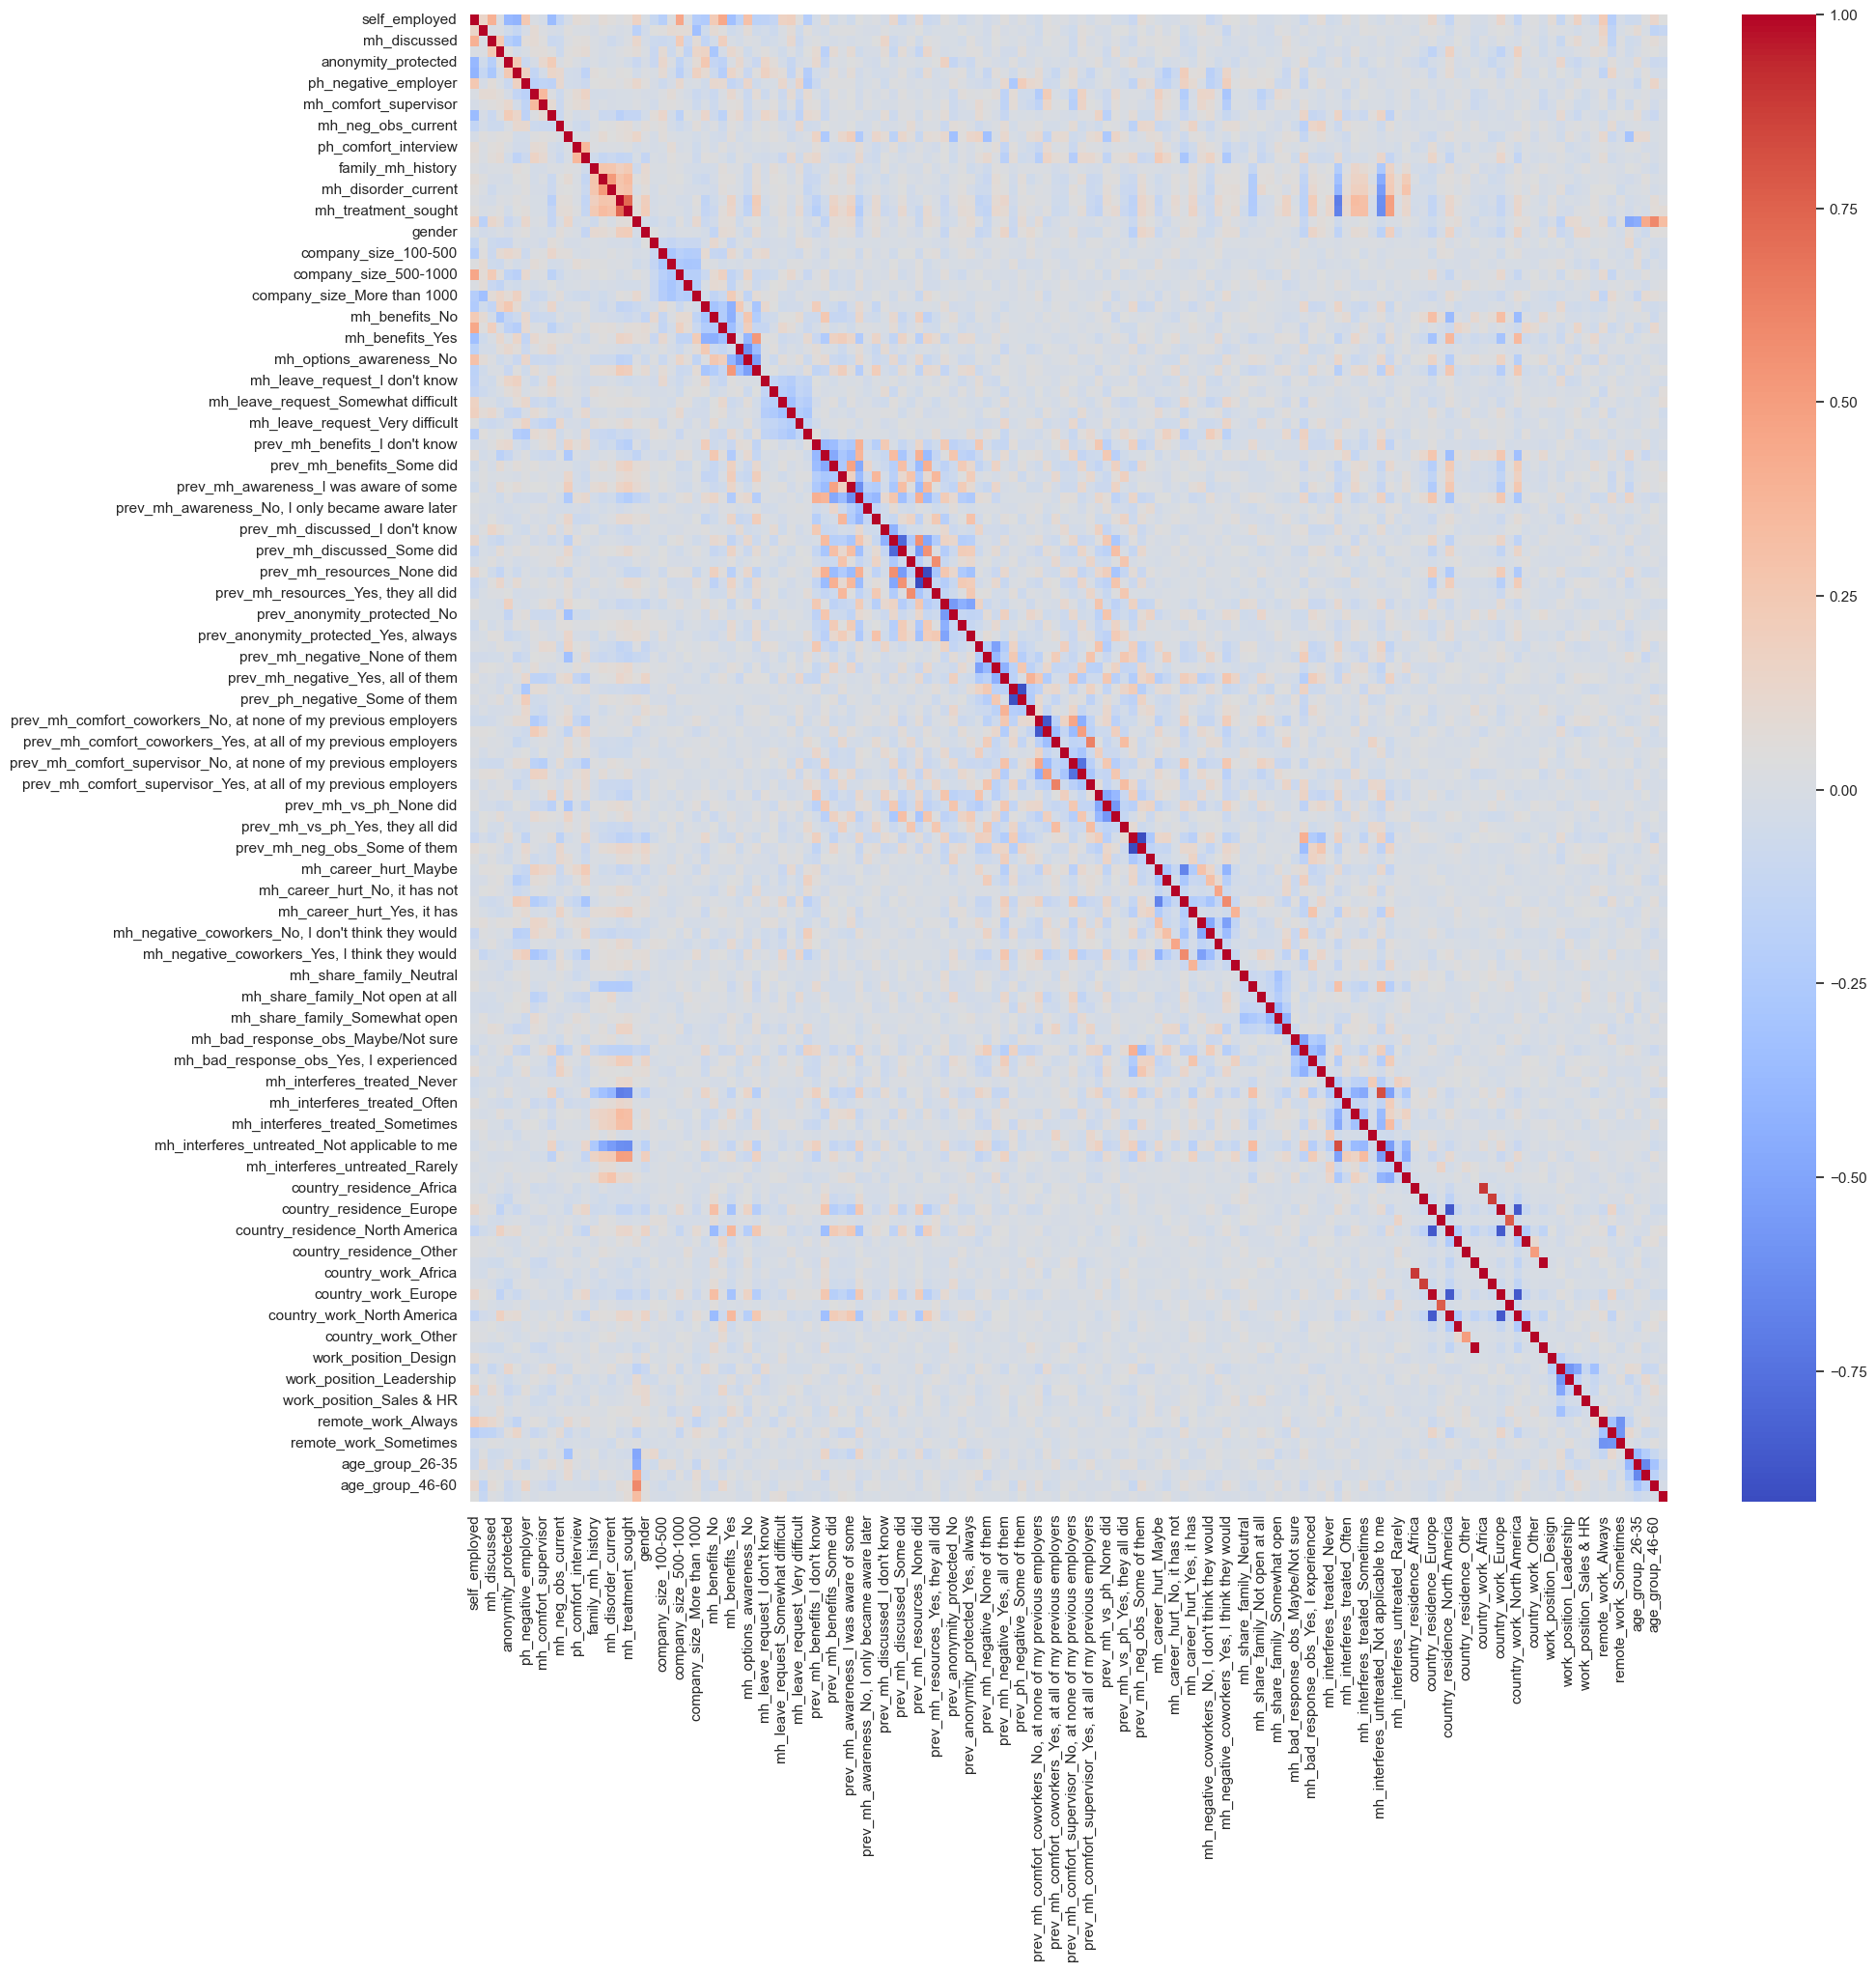

In [74]:
correlation_matrix = df_imputed.corr()

plt.figure(figsize=(20, 20))

# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [75]:
columns_to_drop = df_imputed.filter(regex='^country_work_').columns.to_list() # dropping country_work columns
df_imputed.drop(columns=columns_to_drop, inplace=True)
df_imputed.shape

(1433, 132)

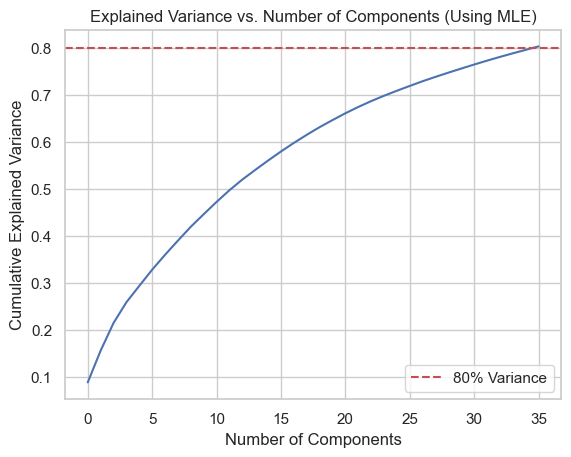

(1433, 36)

In [76]:
pca = PCA(n_components=0.80, random_state=1)  # Using mle to automatically select the number of components
data_pca = pca.fit_transform(df_imputed)
cumulative_variance = pca.explained_variance_ratio_.cumsum()


plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (Using MLE)')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance')
plt.legend()
plt.show()

data_pca.shape

In [77]:
pca = PCA(n_components=36, random_state=1)  # Retain 90% of the variance and choose 60 most important features
data_pca = pca.fit_transform(df_imputed)

pca_columns = [f'PC{i+1}' for i in range(data_pca.shape[1])]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Step 4: Add PCA columns back to the original dataset
df_transformed = pd.concat([df_imputed.reset_index(drop=True), df_pca], axis=1)

Explained Variance Ratio: [0.08832251 0.06754057 0.05880328 0.04421584 0.03483977 0.03447321
 0.03170726 0.03022898 0.0295257  0.02666099 0.02621185 0.02490072
 0.02267845 0.02048898 0.01999929 0.01930275 0.01826495 0.01720488
 0.01636455 0.01499279 0.01454771 0.01337251 0.01249235 0.01138543
 0.01067552 0.01026629 0.01003528 0.00929667 0.00897707 0.00868945
 0.00857195 0.00826143 0.00795881 0.00763397 0.00739127 0.00735983]


In [78]:
df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.454859  0.231551  1.637607 -0.684735  0.011727  0.412207 -1.809105   
1  0.791990  0.655618  1.923728 -0.361449 -1.065693 -0.526795  0.262943   
2 -1.318797 -0.974358  1.170523 -0.024507  0.572650 -0.537436 -2.195591   
3  0.912119  3.274714 -0.242686  0.357317  0.403995  0.433855 -0.877190   
4  2.520190  0.438769 -1.024635  1.053779 -0.025717  1.739651 -1.272611   

        PC8       PC9      PC10  ...      PC27      PC28      PC29      PC30  \
0  0.099971 -1.043392  0.452284  ...  0.633235  0.161008 -0.206199 -0.039701   
1 -0.207494 -0.876102 -1.035372  ... -0.474356 -0.852813  0.635540 -0.405101   
2  0.449044  1.290170  0.866889  ... -0.703604  1.315907  1.018664  0.112886   
3  0.281966 -0.217726 -0.209116  ...  0.267275  0.546424 -0.130475 -0.291747   
4 -0.058683 -0.230740  0.268799  ...  0.450967  1.177160  0.433502 -0.348850   

       PC31      PC32      PC33      PC34      PC35      PC36  
0 -0.280766  0.172511  0.338885  0.195146 -0.111127 -0.726145  
1 -0.245792 -0.032538  0.763400 -0.441973  0.064496 -0.210356  
2 -0.555186  0.426161  0.044306 -0.806545 -0.444735  0.718357  
3  1.469782  0.804051 -0.975912  0.041904  0.058782  0.208410  
4 -0.132496  0.138255  1.018676 -0.010079  0.895052 -0.116892  

[5 rows x 36 columns]

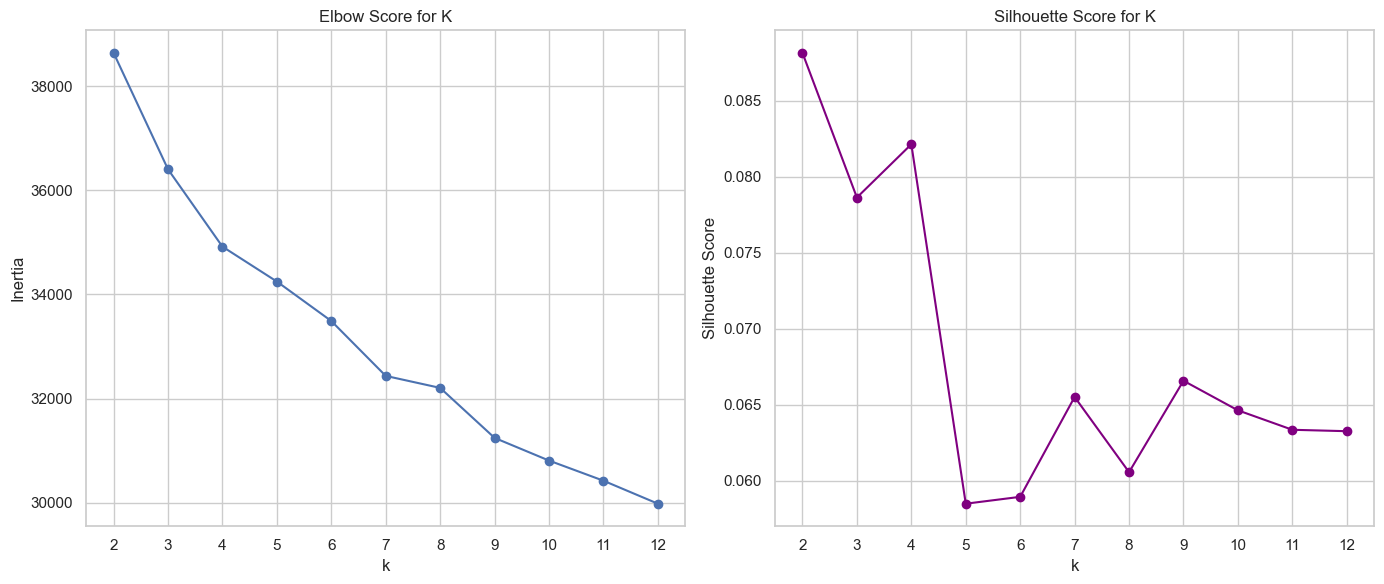

In [79]:
inertia = [] 
kmeans_value = range(2, 13) # for iterating k in range of 2 to 12
silhouette_scores = []

for k in kmeans_value:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1) 
    clusters = kmeans.fit_predict(data_pca)
    silhouette = silhouette_score(data_pca, clusters)
    silhouette_scores.append(silhouette)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(kmeans_value, inertia, marker='o')
plt.title("Elbow Score for K")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(kmeans_value)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(kmeans_value, silhouette_scores, color='purple', marker='o')
plt.title("Silhouette Score for K")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.xticks(kmeans_value)
plt.grid(True)

plt.tight_layout()
plt.show()

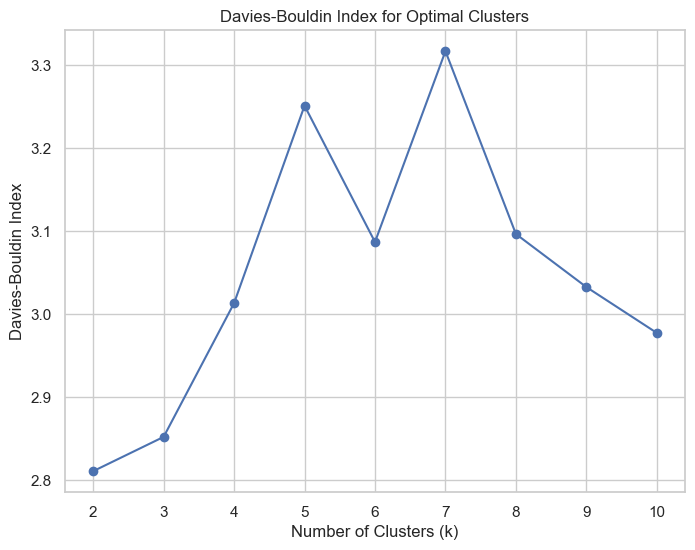

In [80]:

k_range = range(2, 11)
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    db_scores.append(davies_bouldin_score(data_pca, labels))

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.plot(k_range, db_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal Clusters')
plt.show()

In [81]:
kmeans = KMeans(n_clusters=3, max_iter=500, random_state=1) 
label = kmeans.fit_predict(data_pca)

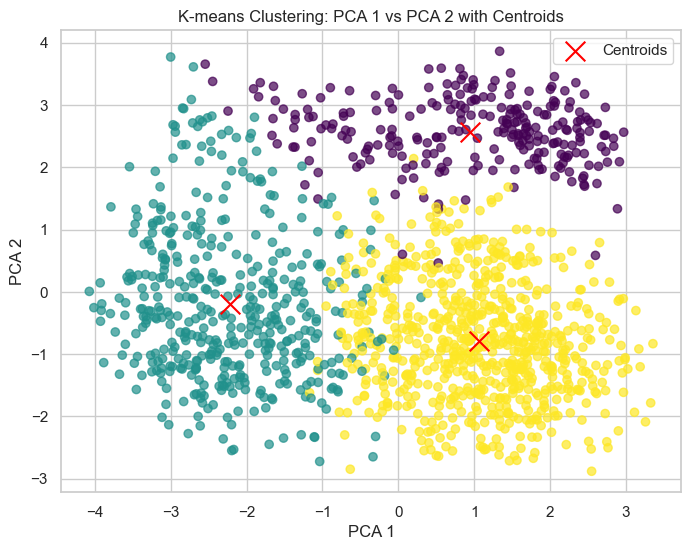

In [82]:
centroids = kmeans.cluster_centers_
df_pca['Cluster'] = label
df_cluster['Cluster'] = label

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title('K-means Clustering: PCA 1 vs PCA 2 with Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

<Axes: xlabel='What is your gender?', ylabel='count'>

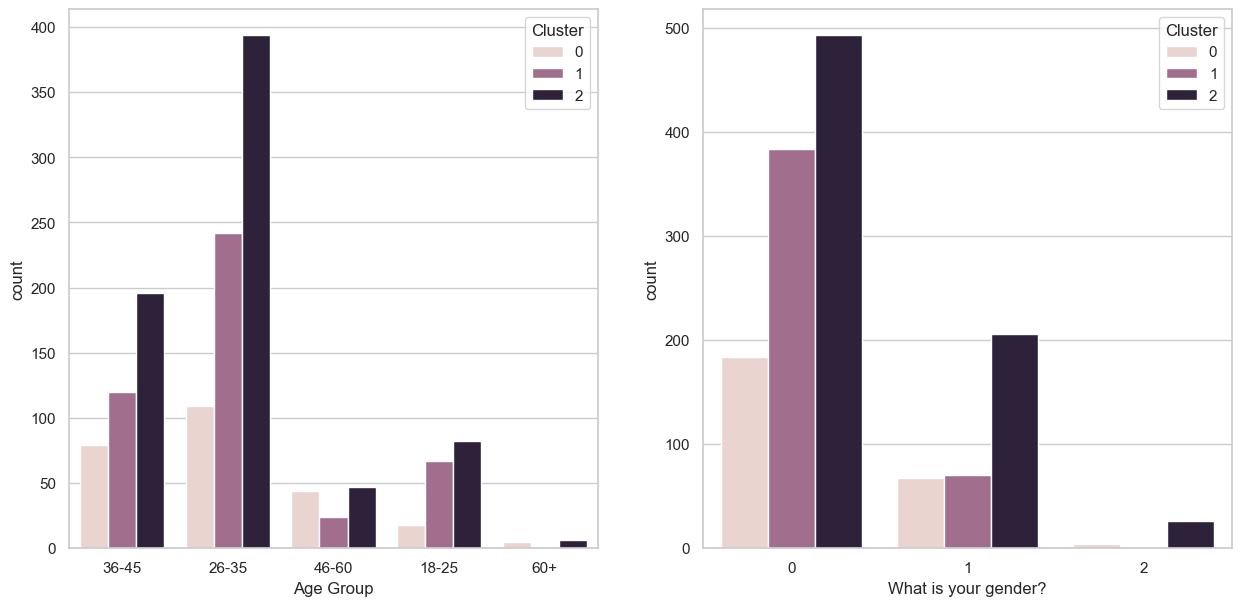

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sns.countplot(ax=ax[0], x = df_cluster['Age Group'], hue = df_cluster["Cluster"])
sns.countplot(ax=ax[1], x= df_cluster['What is your gender?'], hue = df_cluster["Cluster"])

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

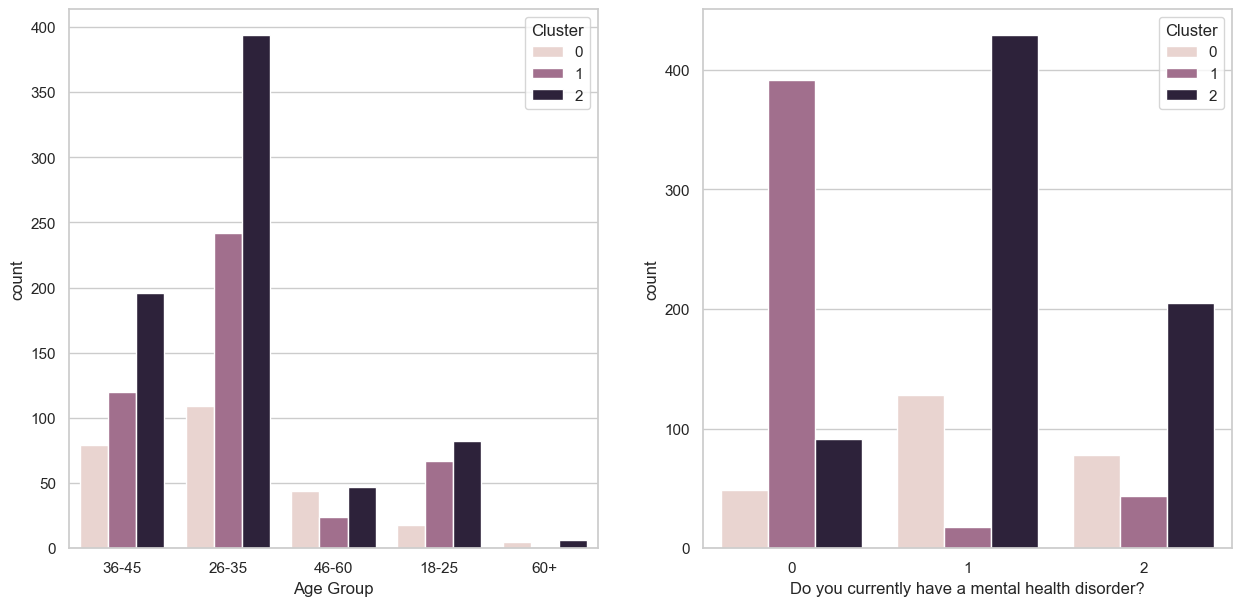

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(ax=ax[0], x = df_cluster['Age Group'], hue = df_cluster["Cluster"])
sns.countplot(ax=ax[1], x= df_cluster['Do you currently have a mental health disorder?'], hue = df_cluster["Cluster"],)

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

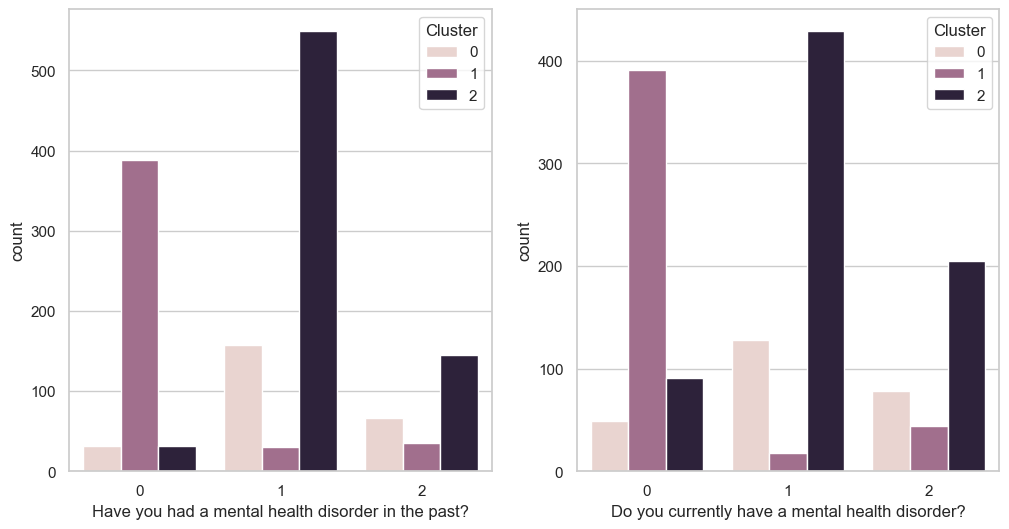

In [85]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
sns.countplot(ax=ax[0], x = df_cluster['Have you had a mental health disorder in the past?'], hue = df_cluster["Cluster"])
sns.countplot(ax=ax[1], x= df_cluster['Do you currently have a mental health disorder?'], hue = df_cluster["Cluster"])

In [86]:
col_for_clustering1 = ['age', 
                      'mh_disorder_current', 'mh_disorder_past',
                      'mh_diagnosed', 'mh_treatment_sought']

In [87]:
pca = PCA(n_components=0.8, random_state=1)  # Retain 85% of the variance and choose 4 most important features
data_pca = pca.fit_transform(df_imputed[col_for_clustering1])

pca_columns = [f'PC{i+1}' for i in range(data_pca.shape[1])]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance), data_pca.shape

Explained Variance Ratio: [0.4451891  0.21026486 0.19370134]


(None, (1433, 3))

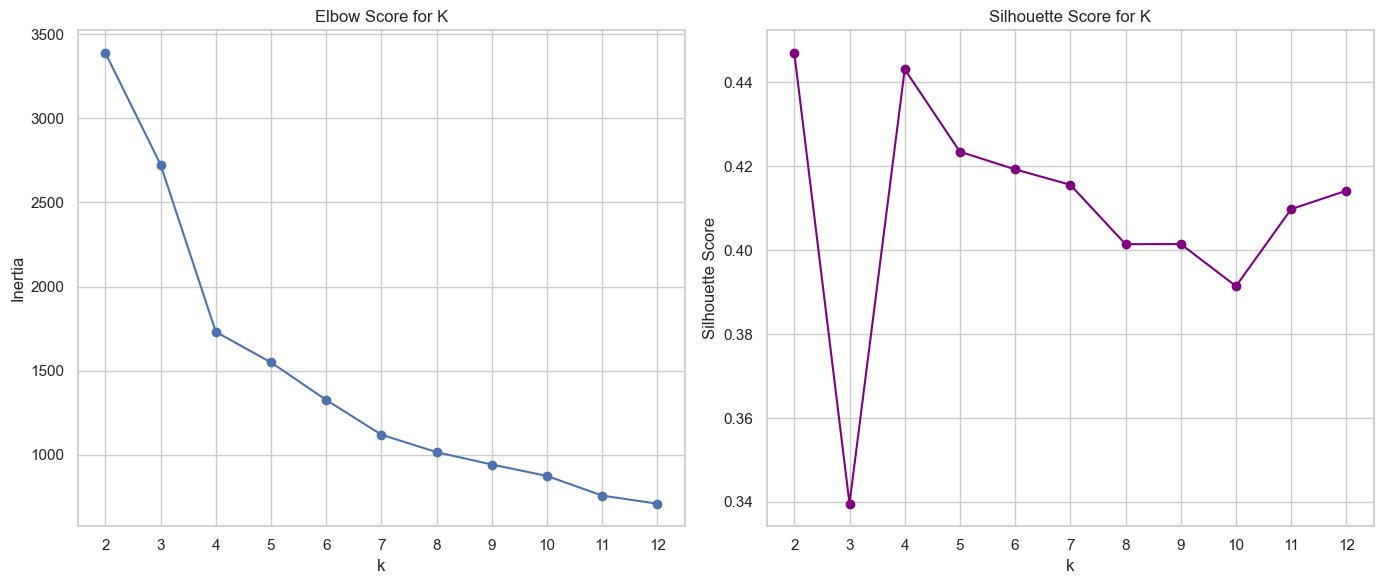

In [88]:
inertia = [] 
kmeans_value = range(2, 13) # for iterating k in range of 2 to 12
silhouette_scores = []

for k in kmeans_value:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1) 
    clusters = kmeans.fit_predict(data_pca)
    silhouette = silhouette_score(data_pca, clusters)
    silhouette_scores.append(silhouette)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(kmeans_value, inertia, marker='o')
plt.title("Elbow Score for K")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(kmeans_value)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(kmeans_value, silhouette_scores, color='purple', marker='o')
plt.title("Silhouette Score for K")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.xticks(kmeans_value)
plt.grid(True)

plt.tight_layout()
plt.show()

In [89]:
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=1) 
label = kmeans.fit_predict(data_pca)

C:\Users\bugra\AppData\Local\Temp\ipykernel_11836\2237280507.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


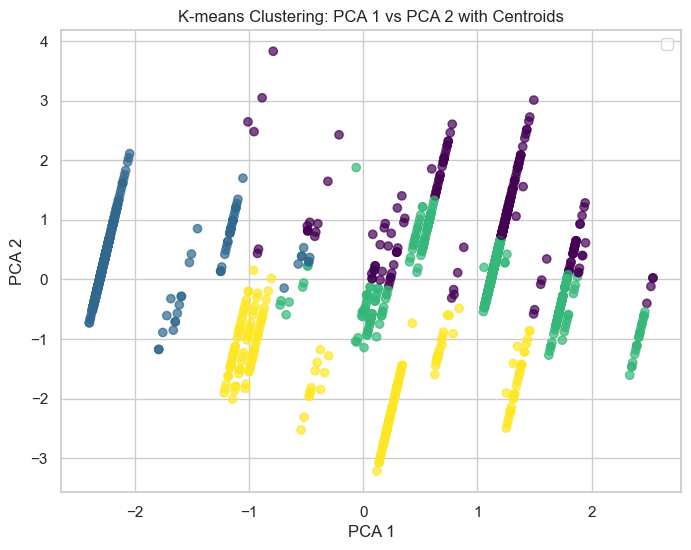

In [90]:
centroids = kmeans.cluster_centers_
df_pca['Cluster'] = label

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.title('K-means Clustering: PCA 1 vs PCA 2 with Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [91]:
df_cluster["Cluster"] = label

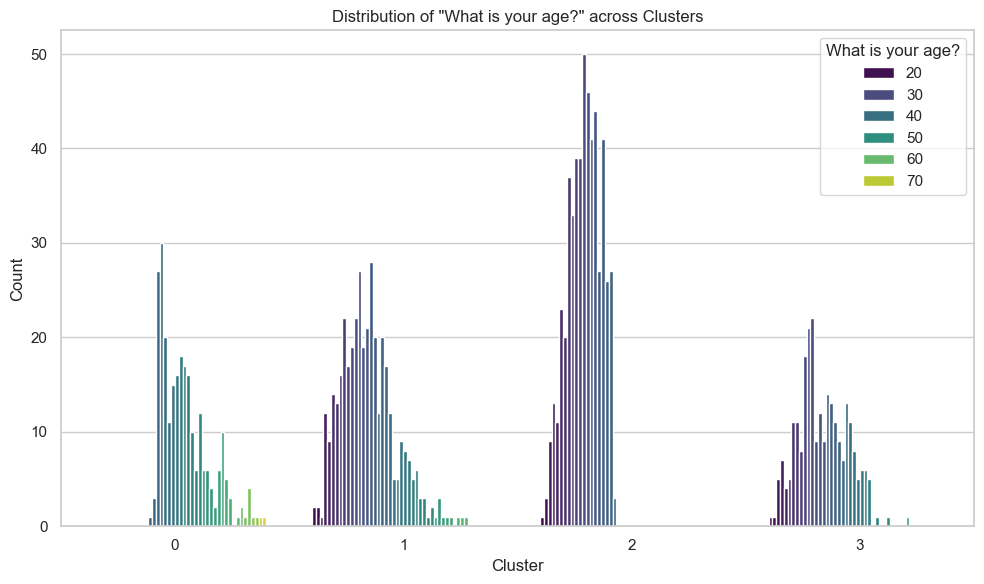

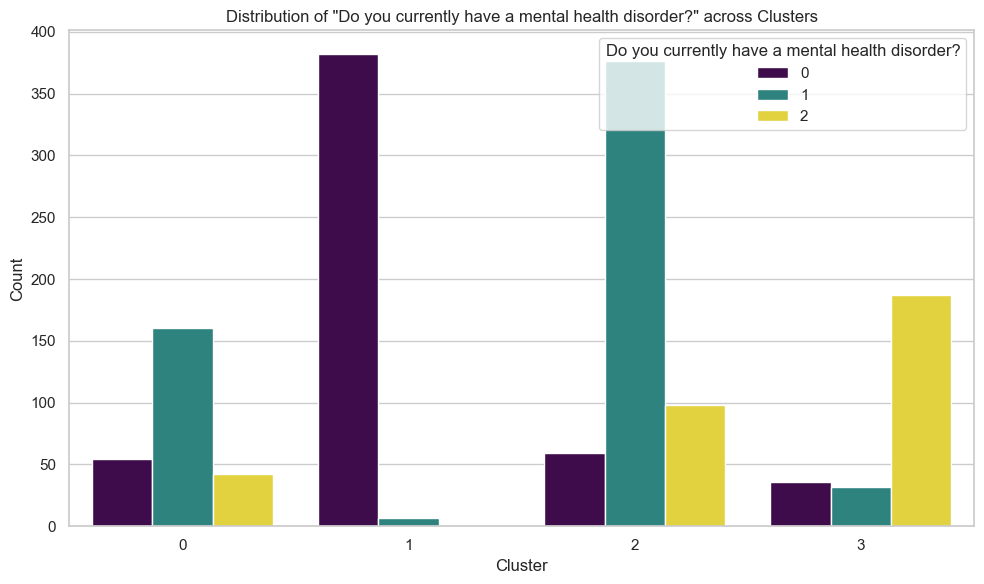

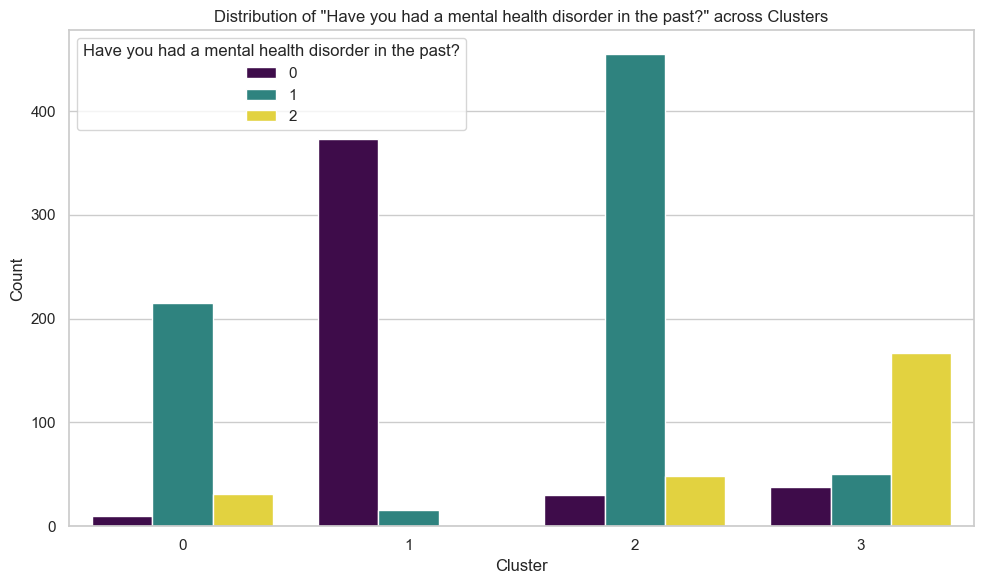

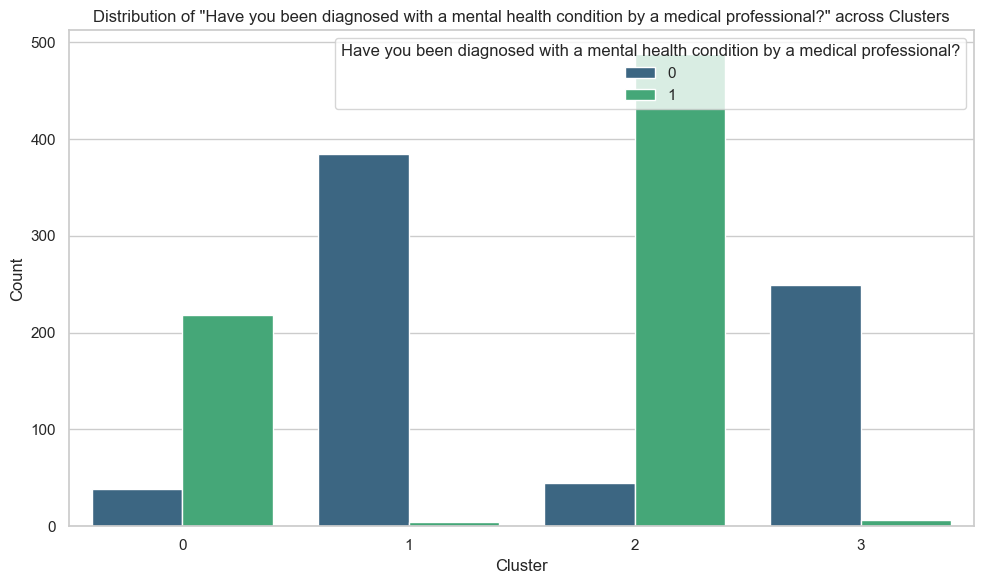

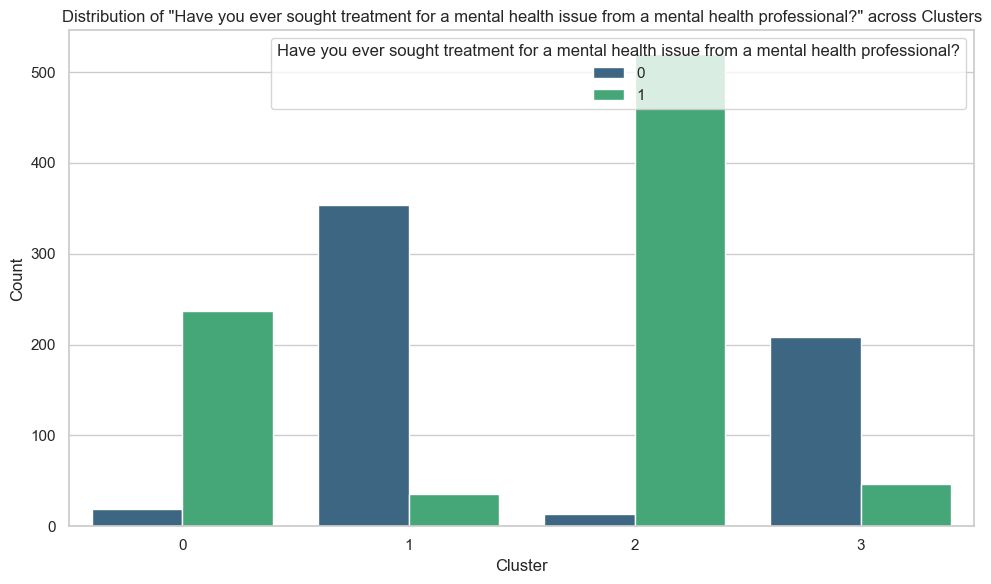

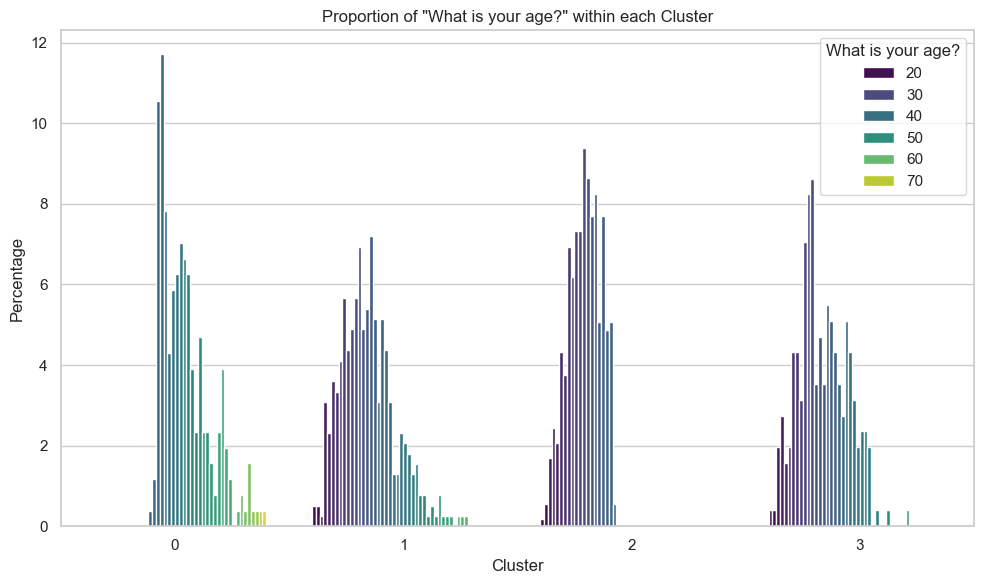

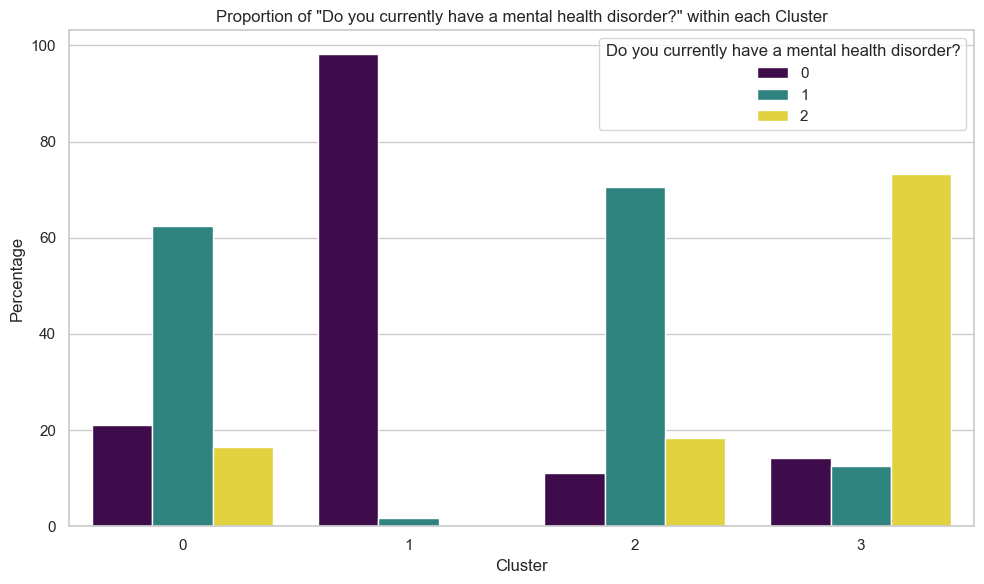

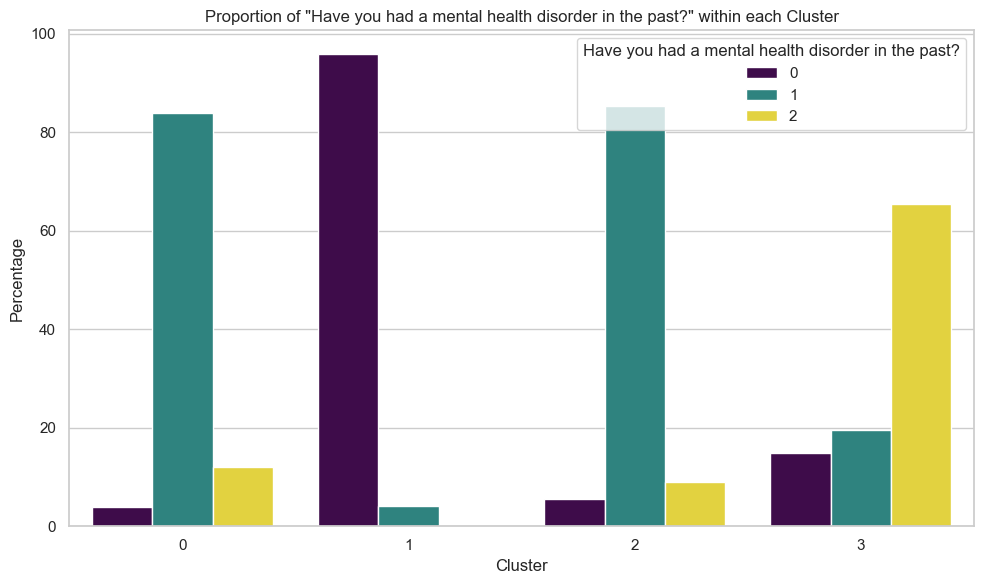

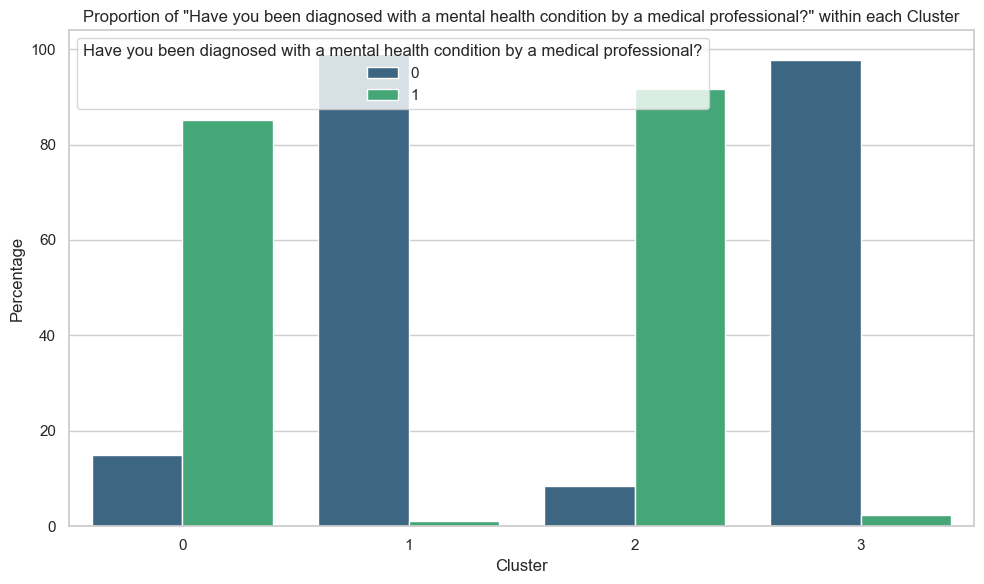

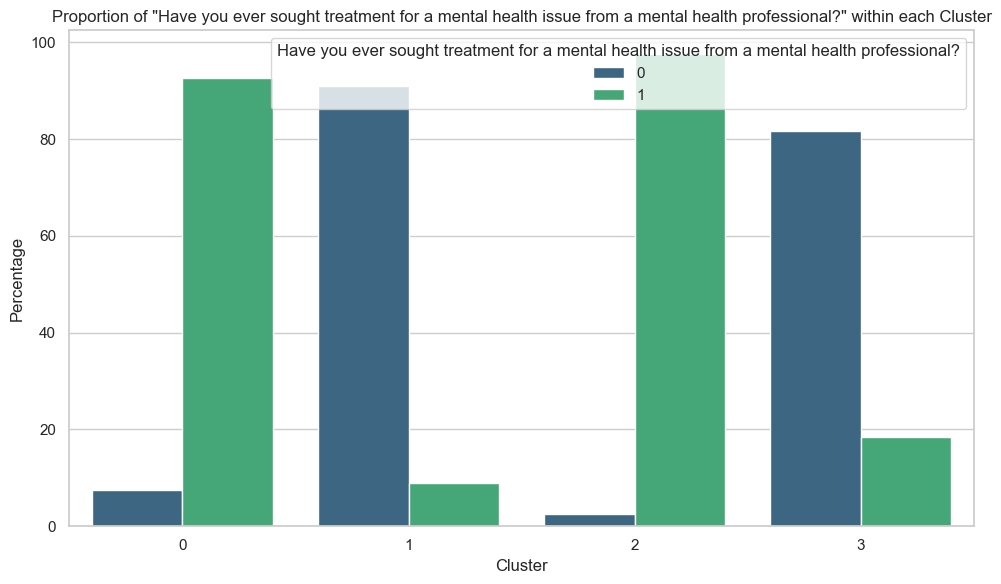

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_clusters(df_new, columns_to_visualize):

    for col in columns_to_visualize:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_new, x='Cluster', hue=col, palette='viridis')
        plt.title(f'Distribution of "{col}" across Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.legend(title=col)
        plt.tight_layout()
        plt.show()

def visualize_cluster_proportions(df_new, columns_to_visualize):
    for col in columns_to_visualize:
        plt.figure(figsize=(10, 6))
        # Calculate proportions within each cluster
        cluster_proportions = df_new.groupby('Cluster')[col].value_counts(normalize=True).mul(100).rename('percent').reset_index()
        sns.barplot(data=cluster_proportions, x='Cluster', y='percent', hue=col, palette='viridis')
        plt.title(f'Proportion of "{col}" within each Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Percentage')
        plt.xticks(rotation=0)
        plt.legend(title=col)
        plt.tight_layout()
        plt.show()

col_for_clustering2 = ['What is your age?', 
                      'Do you currently have a mental health disorder?', 'Have you had a mental health disorder in the past?',
                      'Have you been diagnosed with a mental health condition by a medical professional?',
                      'Have you ever sought treatment for a mental health issue from a mental health professional?']

# Visualize the counts of each category in each cluster
visualize_clusters(df_cluster, col_for_clustering2)

# Visualize the proportions of each category within each cluster
visualize_cluster_proportions(df_cluster, col_for_clustering2)

### We can now profile our clusters based on the data we have and then continue to extract insights using those profiled clusters

### Cluster 0
- **Age**: 45 to 75
- **Currently have mh disorder**: mostly yes
- **Had mh disorder in past**: yes
- **Diagnosed MH by med pro**: yes
- **Have sought treatment by med pro**: yes
- **Label**: Senior MH Diagnosed

**Profile**:
- Older demographic with established mental health conditions
- Consistent history of diagnosis and treatment
- Actively engaged with mental health care

### Cluster 1
- **Age**: 20 to 55
- **Currently have mh disorder**: No
- **Had mh disorder in past**: no
- **Diagnosed MH by med pro**: no
- **Have sought treatment by med pro**: no
- **Label**: Middle Aged No MH

**Profile**:
- Wide age range of adults
- No history of mental health issues
- No interaction with mental health professional

### Cluster 2
- **Age**: 20 to 35
- **Currently have mh disorder**: yes
- **Had mh disorder in past**: yes
- **Diagnosed MH by med pro**: yes
- **Have sought treatment by med pro**: yes
- **Label**: Young Adults MH Diagnosed

**Profile**:
- Young adults
- Active mental health conditions
- Diagnosed and receiving treatment

### Cluster 3
- **Age**: 20 to 45
- **Currently have mh disorder**: not sure
- **Had mh disorder in past**: not sure
- **Diagnosed MH by med pro**: no
- **Have sought treatment by med pro**: no
- **Label**: MH Uncertain

**Profile**:
- Young to middle-aged adults
- Uncertain about their mental health status
- No formal diagnosis or treatment
- Potential undiagnosed cases


In [93]:
label_mapping = {
    0: "Senior MH Diagnosed",
    1: "Middle Aged No MH",
    2: "Young Adults MH Diagnosed",
    3: "MH Uncertain"
}

df_cluster['Cluster Profile'] = df_cluster['Cluster'].map(label_mapping)


In [94]:
df_cluster.head()

Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                           500-1000           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                  1         
1                                                  1         
2                                                  1         
3                                                  1         
4                                                  0         

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                 No                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                 No                                                
1                                                Yes                                                
2                                                 No                                                
3                                      I am not sure                                                
4                                                Yes                                                

   Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                  0                                                                                        
1                                                  1                                                                                        
2                                                  0                                                                                        
3                                                  1                                                                                        
4                                                  0                                                                                        

   Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                  0                                                             
1                                                  1                                                             
2                                                  0                                                             
3                                                  1                                                             
4                                                  0                                                             

   Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?  \
0                                                  2                                                                                                
1                                                  1                                                          

In [95]:
def revert_gender_vals(col):
    unique_vals = col.unique()
    if set(unique_vals) == {0, 1, 2}:
        mapping = {0: 'Male', 1: 'Female', 2: 'Other'}
    return col.map(mapping)

In [96]:
df_cluster['What is your gender?'] = revert_gender_vals(df_cluster['What is your gender?'])

In [97]:
df_c0_senior_mh = df_cluster[df_cluster['Cluster'] == 0]
df_c1_middle_no_mh = df_cluster[df_cluster['Cluster'] == 1]
df_c2_young_mh = df_cluster[df_cluster['Cluster'] == 2]
df_c3_mh_uncertain = df_cluster[df_cluster['Cluster'] == 3]

In [98]:
df_cluster["Cluster"].value_counts()

Cluster
2    533
1    389
0    256
3    255
Name: count, dtype: int64

In [99]:
def create_pie_chart(data, column, title="Distribution"):
    """
    Creates a pie chart for a specified column in a dataset
    
    Parameters:
    data: DataFrame
    column: str (column name)
    title: str (chart title)
    """
    plt.figure(figsize=(6, 6))
    value_counts = data[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(title)
    plt.axis('equal')
    plt.show()

def create_bar_plot(data, x_col, y_col=None, title="Bar Plot"):
    """
    Creates a bar plot comparing two columns
    
    Parameters:
    data: DataFrame
    x_col: str (x-axis column name)
    y_col: str (y-axis column name)
    title: str (chart title)
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x=x_col, y=y_col)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

def create_count_plot_with_hue(data, x_col, hue_col=None, title="Count Plot"):
    """
    Creates a count plot with hue
    
    Parameters:
    data: DataFrame
    x_col: str (x-axis column name)
    hue_col: str (hue column name)
    title: str (chart title)
    """
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, hue=hue_col)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(x_col)
    plt.ylabel("Count")
    plt.legend(title=hue_col)
    plt.tight_layout()
    plt.show()

def create_separate_countplots(data, col1, col2, title1="Count Plot 1", title2="Count Plot 2"):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First countplot
    sns.countplot(data=data, x=col1, ax=ax1)
    ax1.set_title(title1)
    ax1.set_xlabel(col1)
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=45)
    
    # Second countplot
    sns.countplot(data=data, x=col2, ax=ax2)
    ax2.set_title(title2)
    ax2.set_xlabel(col2)
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

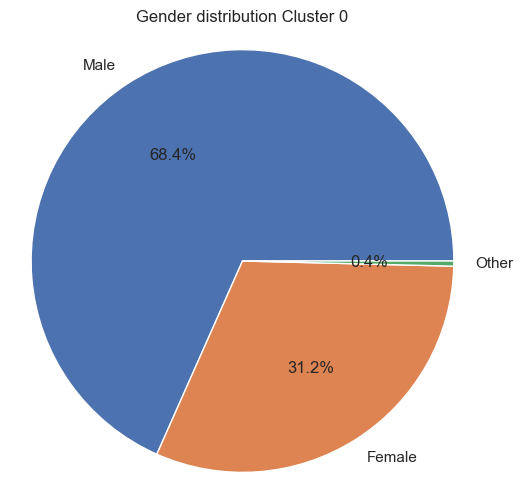

In [100]:
create_pie_chart(df_c0_senior_mh, 'What is your gender?', title="Gender distribution Cluster 0")

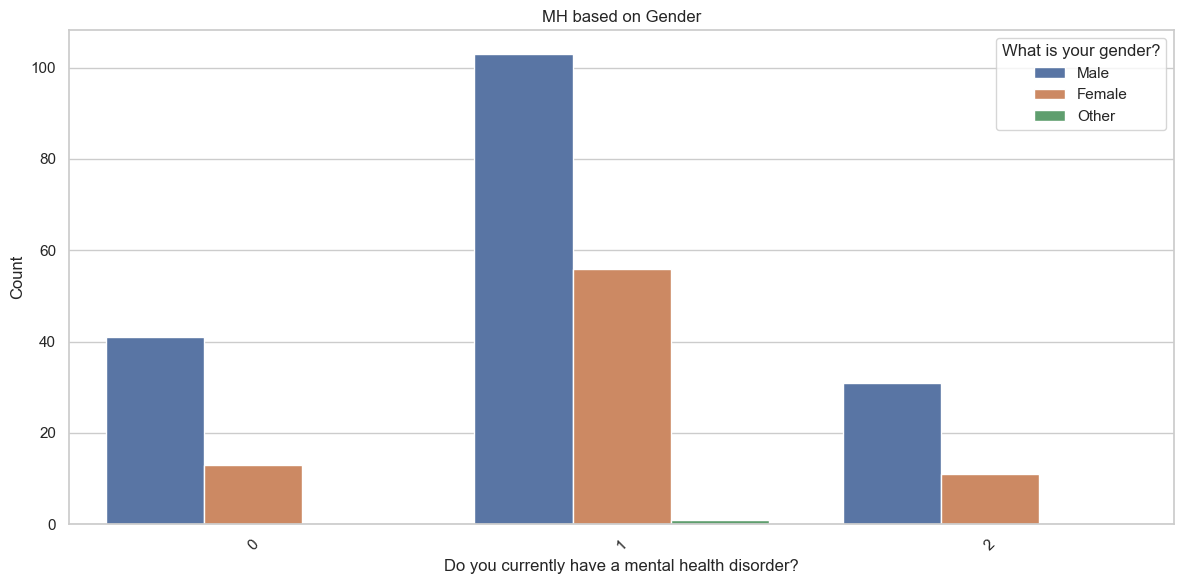

In [101]:
create_count_plot_with_hue(df_c0_senior_mh, 'Do you currently have a mental health disorder?',
                           'What is your gender?',
                            'MH based on Gender')

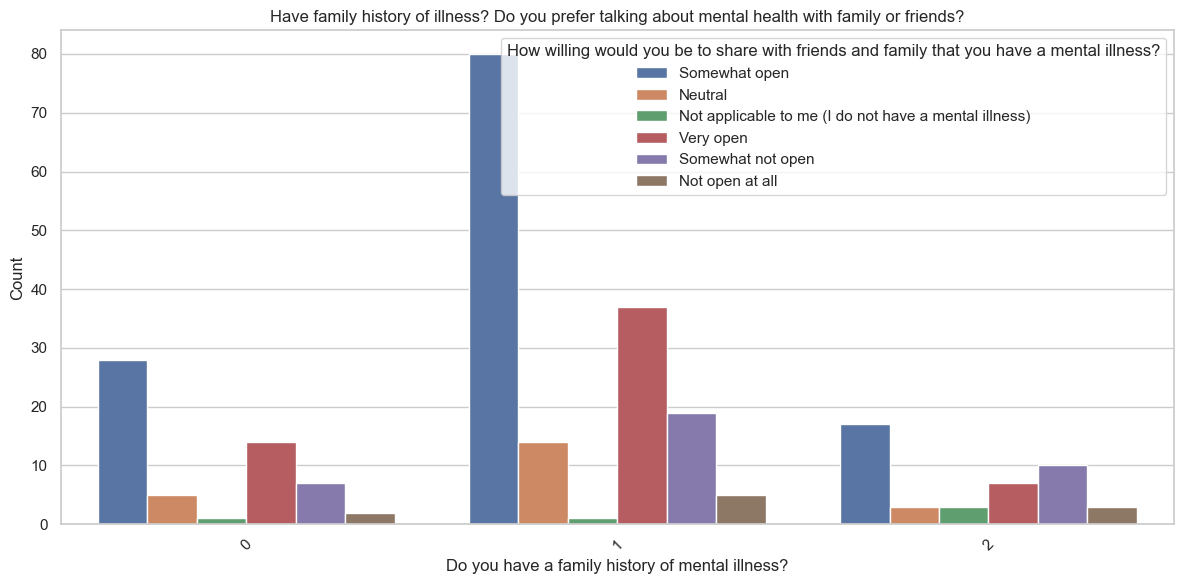

In [102]:
create_count_plot_with_hue(df_c0_senior_mh, x_col='Do you have a family history of mental illness?', 
                           hue_col='How willing would you be to share with friends and family that you have a mental illness?',
                           title='Have family history of illness? Do you prefer talking about mental health with family or friends?')

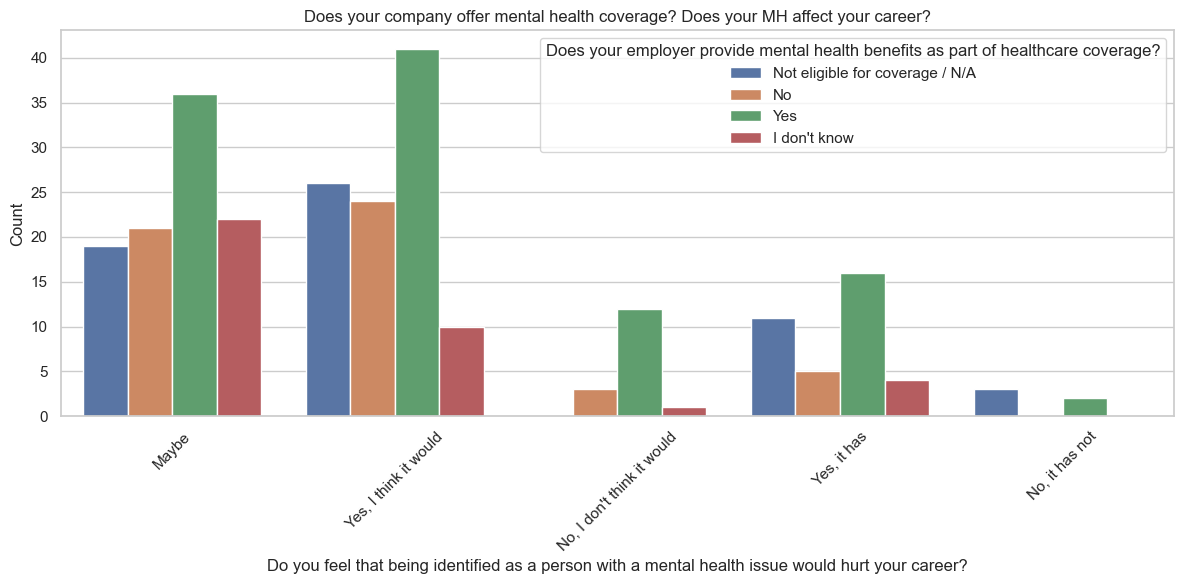

In [103]:
create_count_plot_with_hue(df_c0_senior_mh, "Do you feel that being identified as a person with a mental health issue would hurt your career?",
                           'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Does your company offer mental health coverage? Does your MH affect your career?')

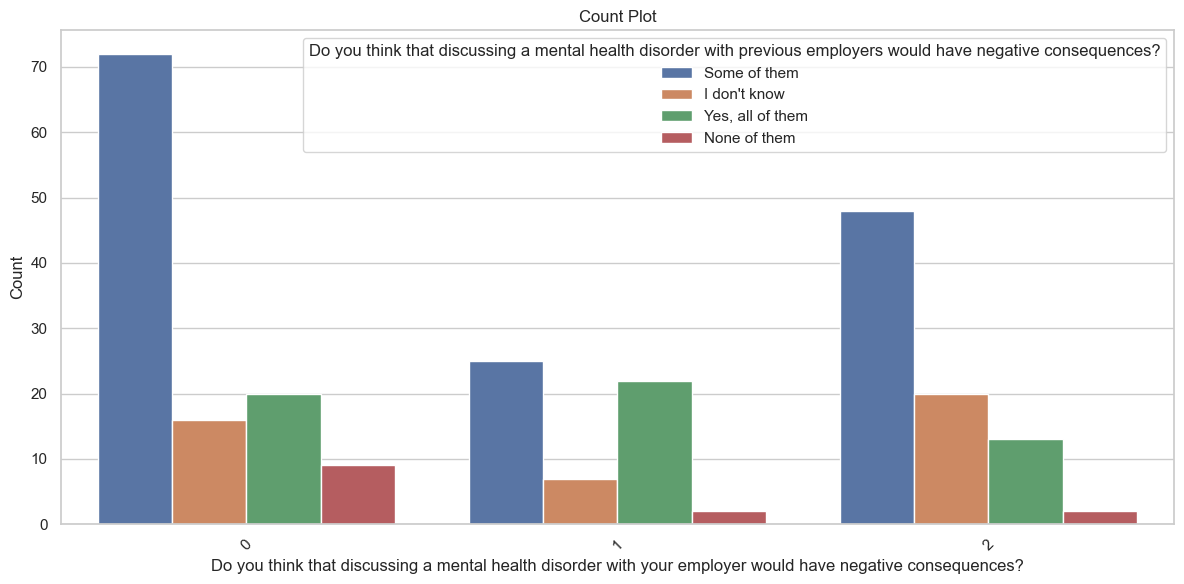

In [104]:
create_count_plot_with_hue(df_c0_senior_mh, 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
                           'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',)

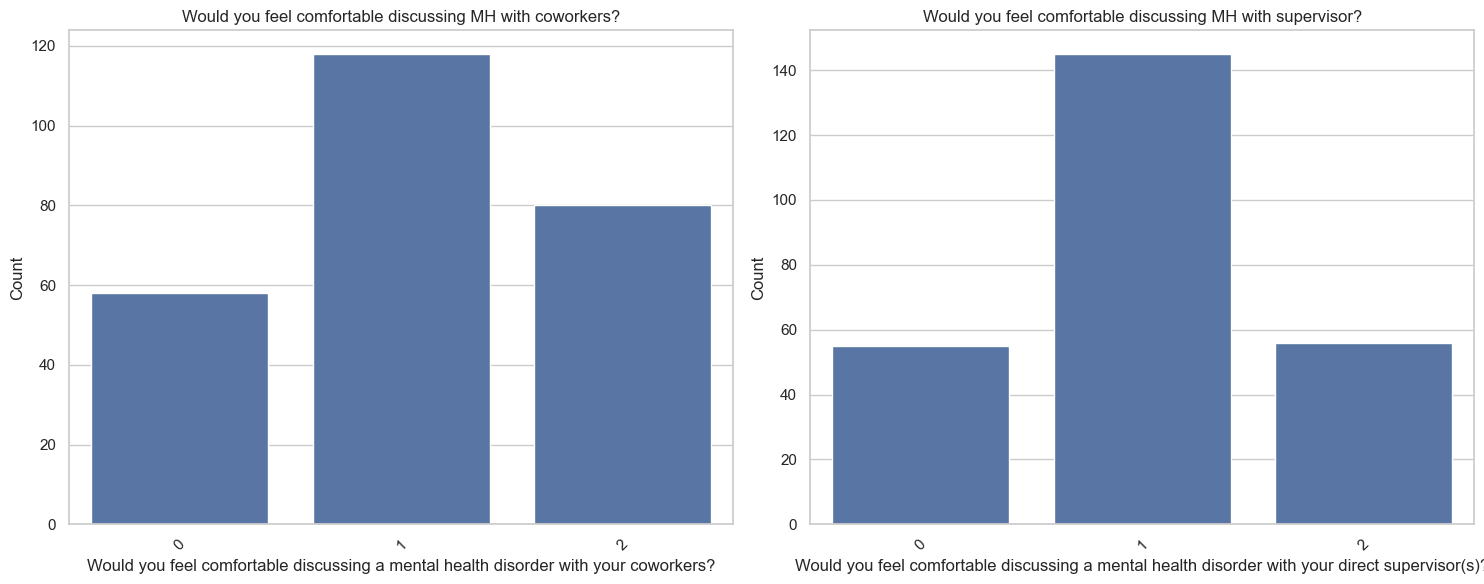

In [105]:
create_separate_countplots(df_c0_senior_mh, 'Would you feel comfortable discussing a mental health disorder with your coworkers?',
                           'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                           title1='Would you feel comfortable discussing MH with coworkers?',
                           title2='Would you feel comfortable discussing MH with supervisor?')

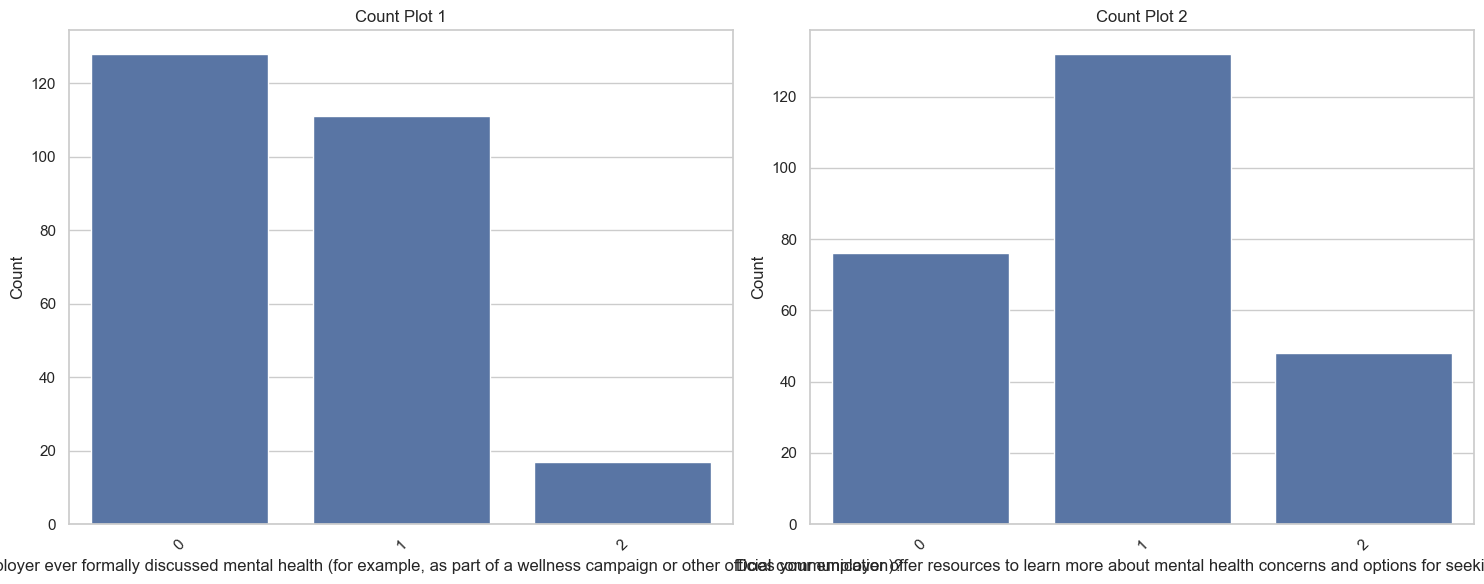

In [106]:
create_separate_countplots(df_c0_senior_mh, 
                           'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
                           'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')

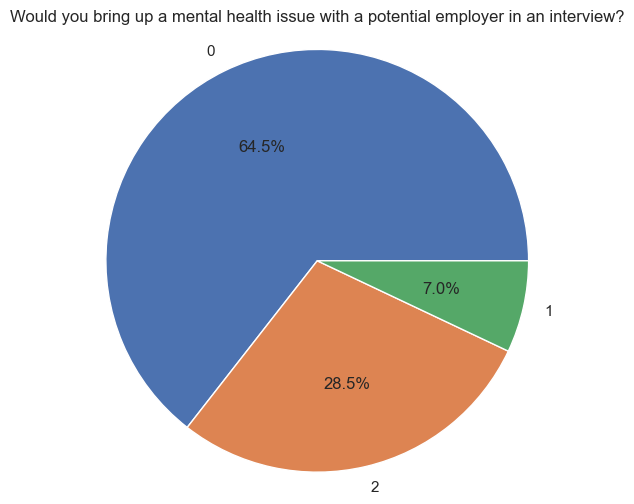

In [107]:
create_pie_chart(df_c0_senior_mh, 'Would you bring up a mental health issue with a potential employer in an interview?',
                title='Would you bring up a mental health issue with a potential employer in an interview?')

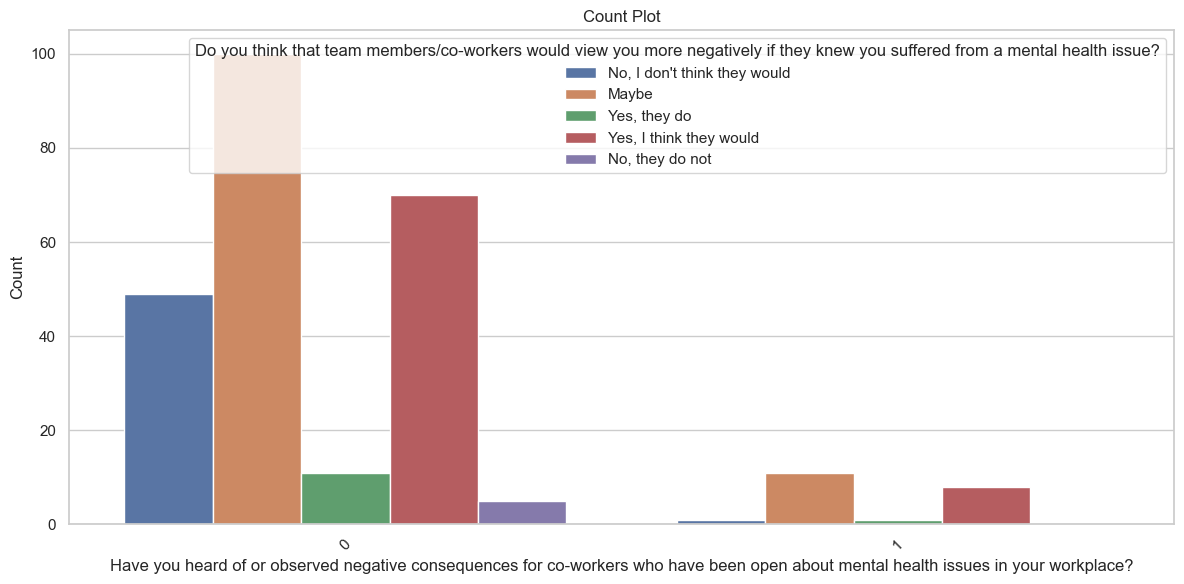

In [108]:
create_count_plot_with_hue(df_c0_senior_mh, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
                           'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?')

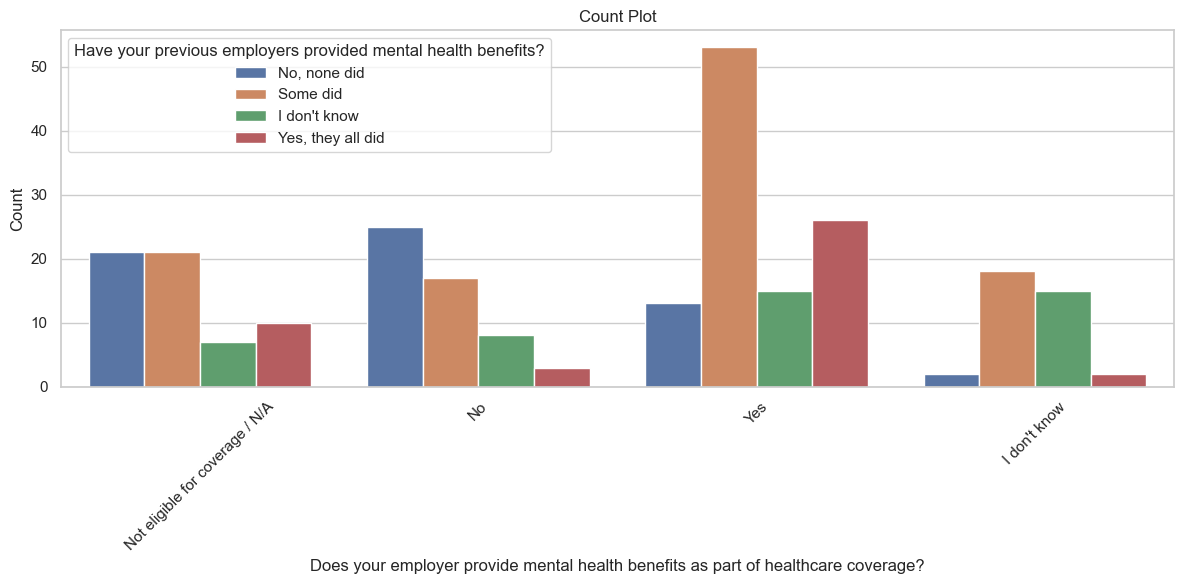

In [109]:
create_count_plot_with_hue(df_c0_senior_mh, 'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Have your previous employers provided mental health benefits?',)

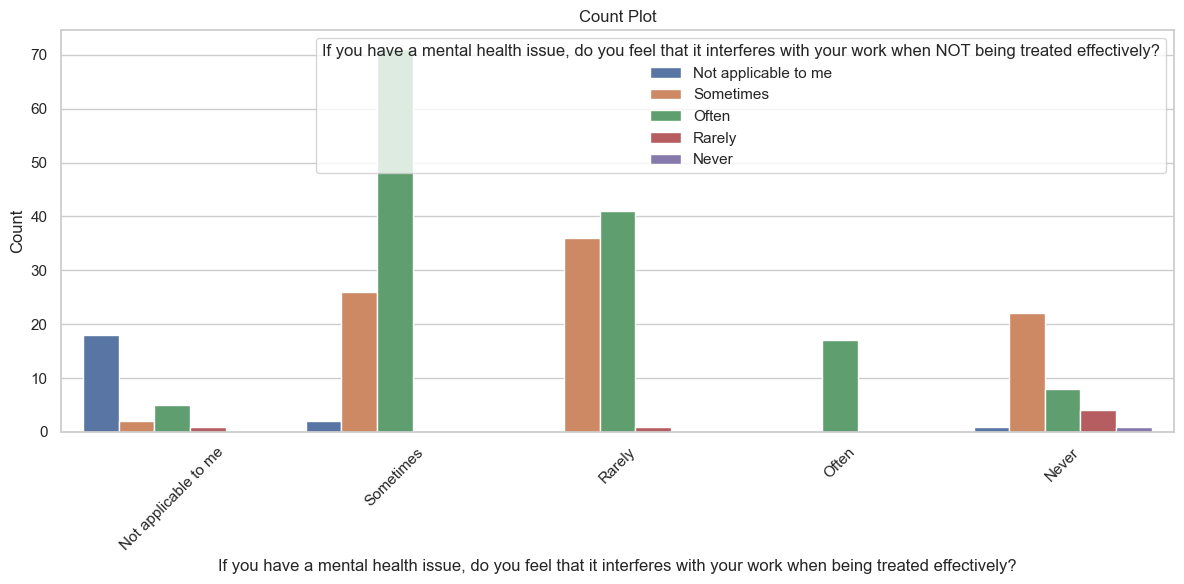

In [110]:
create_count_plot_with_hue(df_c0_senior_mh, 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
               'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?')

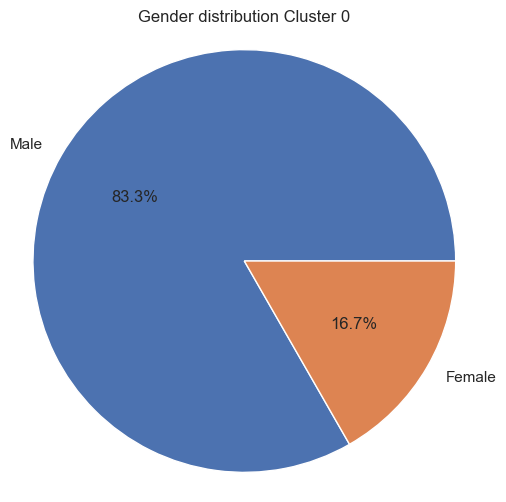

In [111]:
create_pie_chart(df_c1_middle_no_mh, 'What is your gender?', title="Gender distribution Cluster 0")

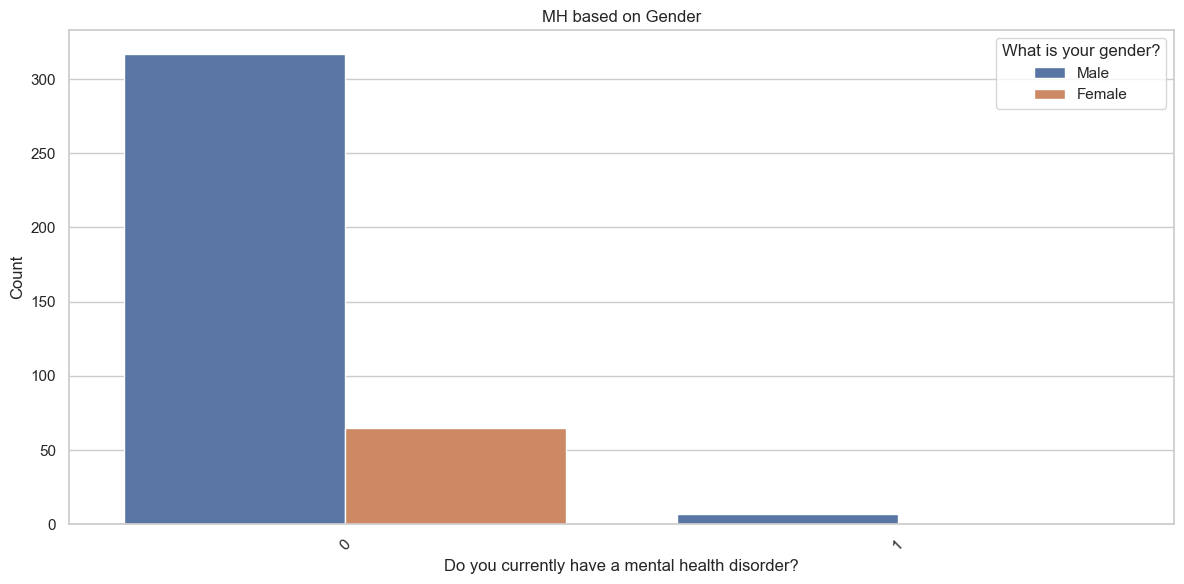

In [112]:
create_count_plot_with_hue(df_c1_middle_no_mh, 'Do you currently have a mental health disorder?',
                           'What is your gender?',
                            'MH based on Gender')

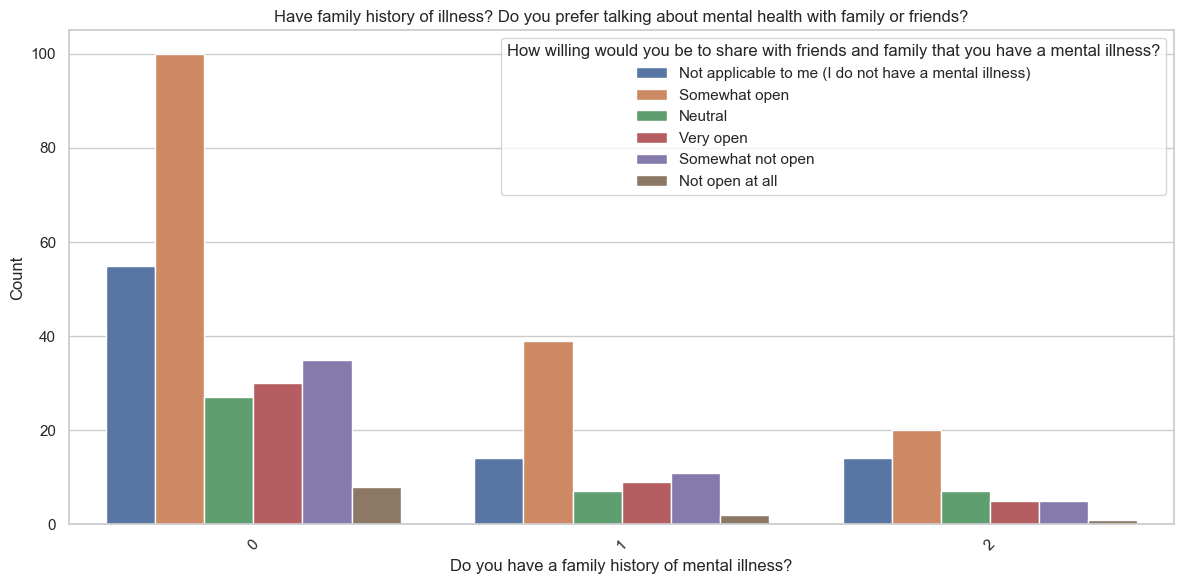

In [113]:
create_count_plot_with_hue(df_c1_middle_no_mh, x_col='Do you have a family history of mental illness?', 
                           hue_col='How willing would you be to share with friends and family that you have a mental illness?',
                           title='Have family history of illness? Do you prefer talking about mental health with family or friends?')

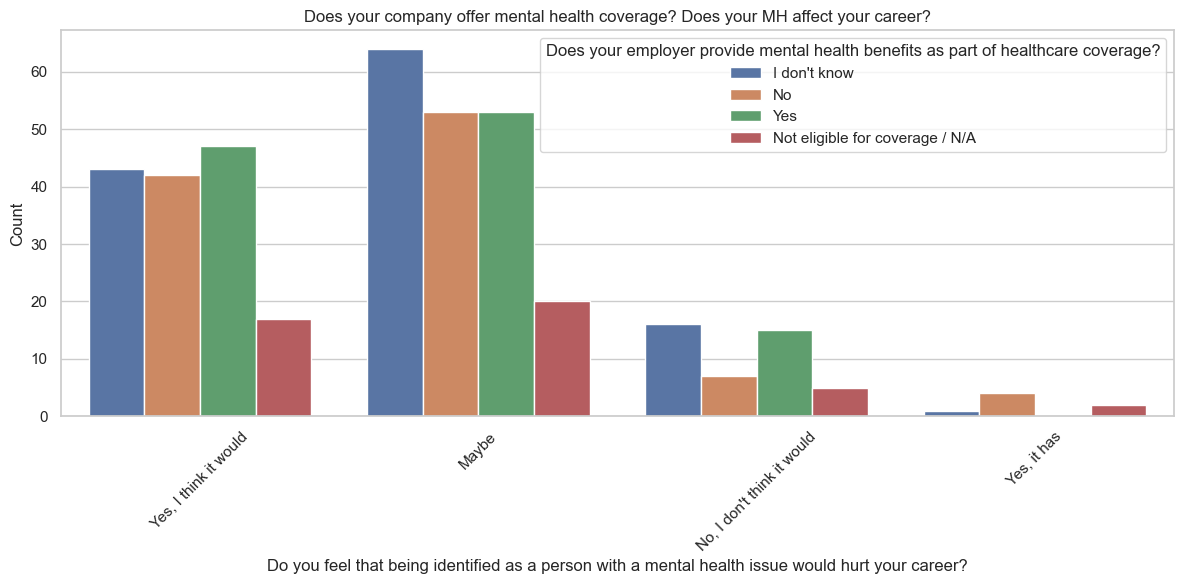

In [114]:
create_count_plot_with_hue(df_c1_middle_no_mh, "Do you feel that being identified as a person with a mental health issue would hurt your career?",
                           'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Does your company offer mental health coverage? Does your MH affect your career?')

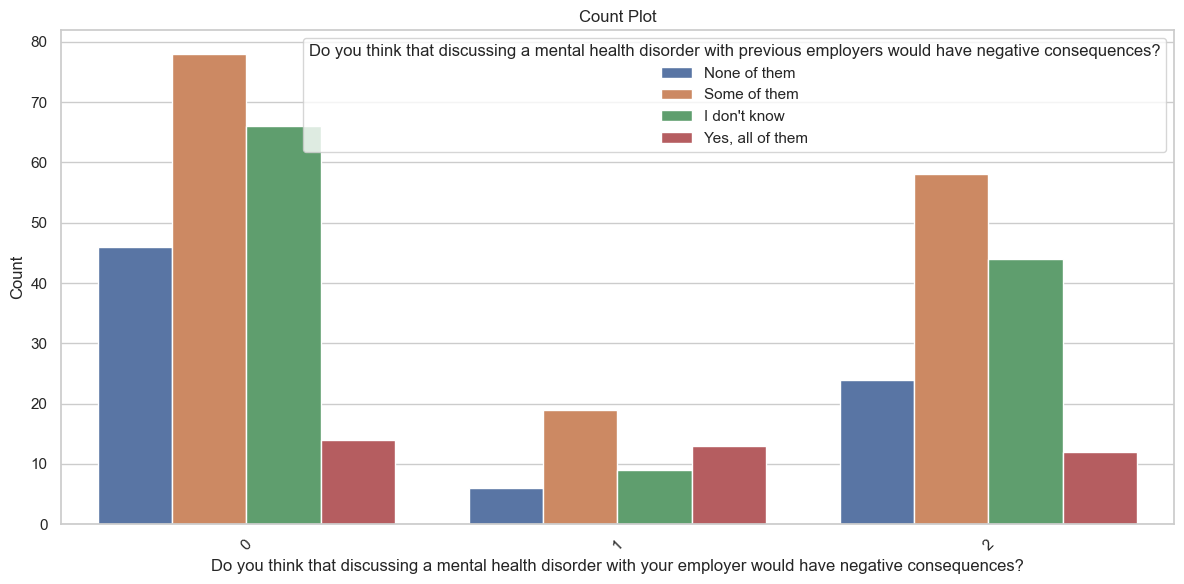

In [115]:
create_count_plot_with_hue(df_c1_middle_no_mh, 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
                           'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',)

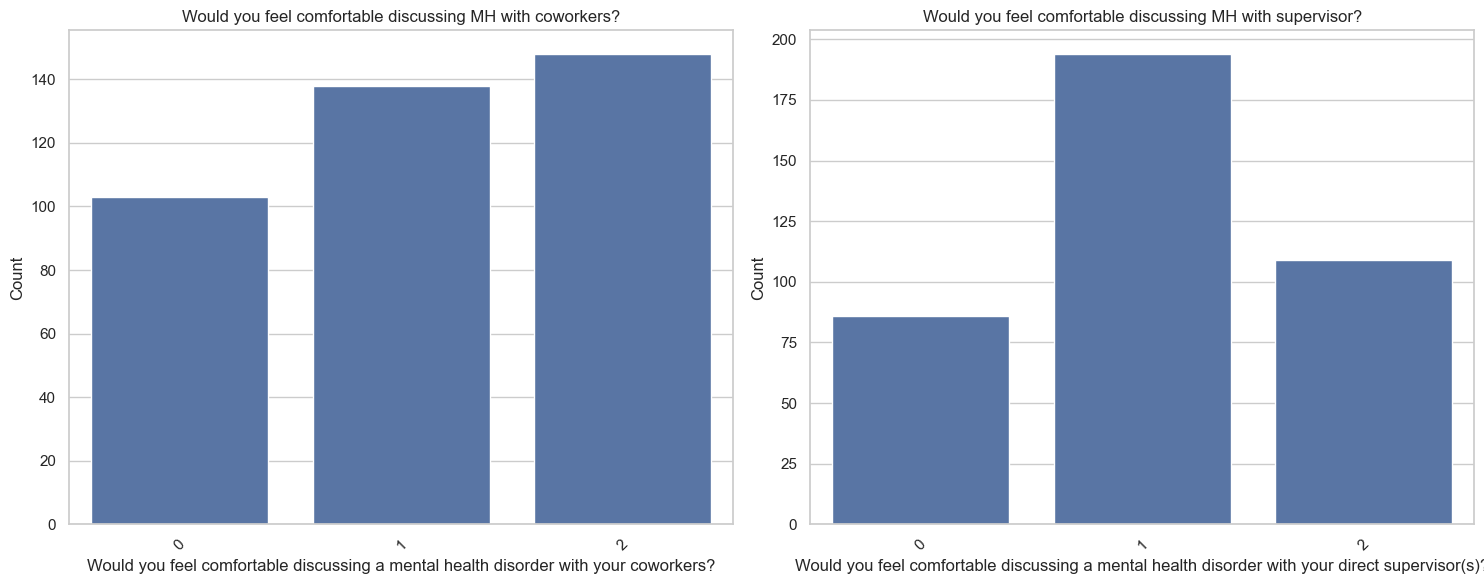

In [116]:
create_separate_countplots(df_c1_middle_no_mh, 'Would you feel comfortable discussing a mental health disorder with your coworkers?',
                           'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                           title1='Would you feel comfortable discussing MH with coworkers?',
                           title2='Would you feel comfortable discussing MH with supervisor?')

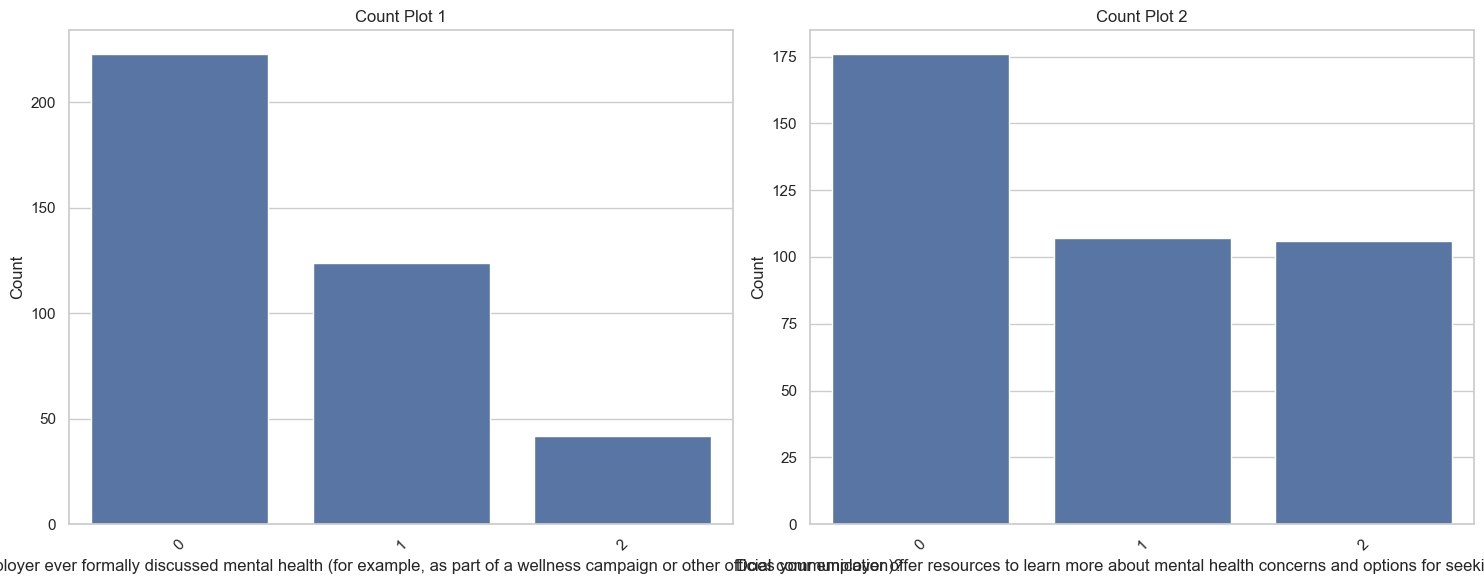

In [118]:
create_separate_countplots(df_c1_middle_no_mh, 
                           'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
                           'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')

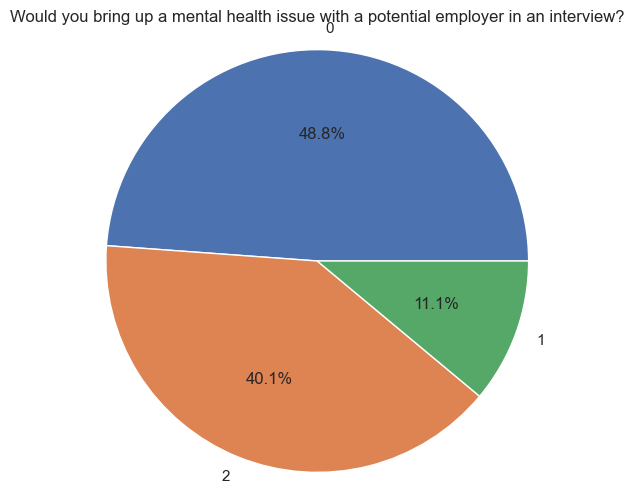

In [119]:
create_pie_chart(df_c1_middle_no_mh, 'Would you bring up a mental health issue with a potential employer in an interview?',
                title='Would you bring up a mental health issue with a potential employer in an interview?')

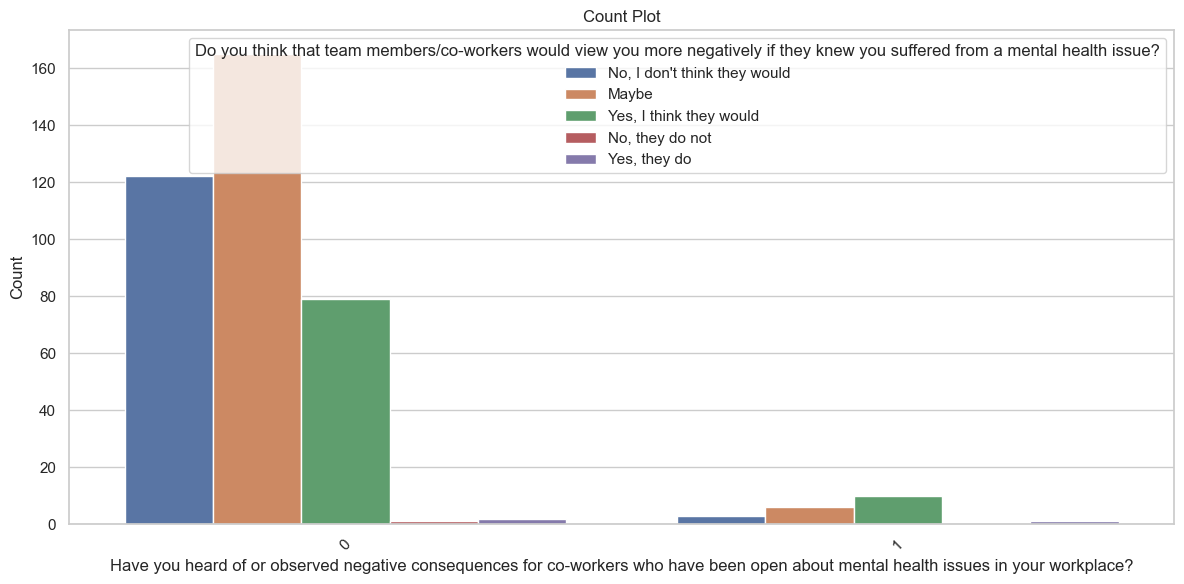

In [121]:
create_count_plot_with_hue(df_c1_middle_no_mh, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
                           'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?')

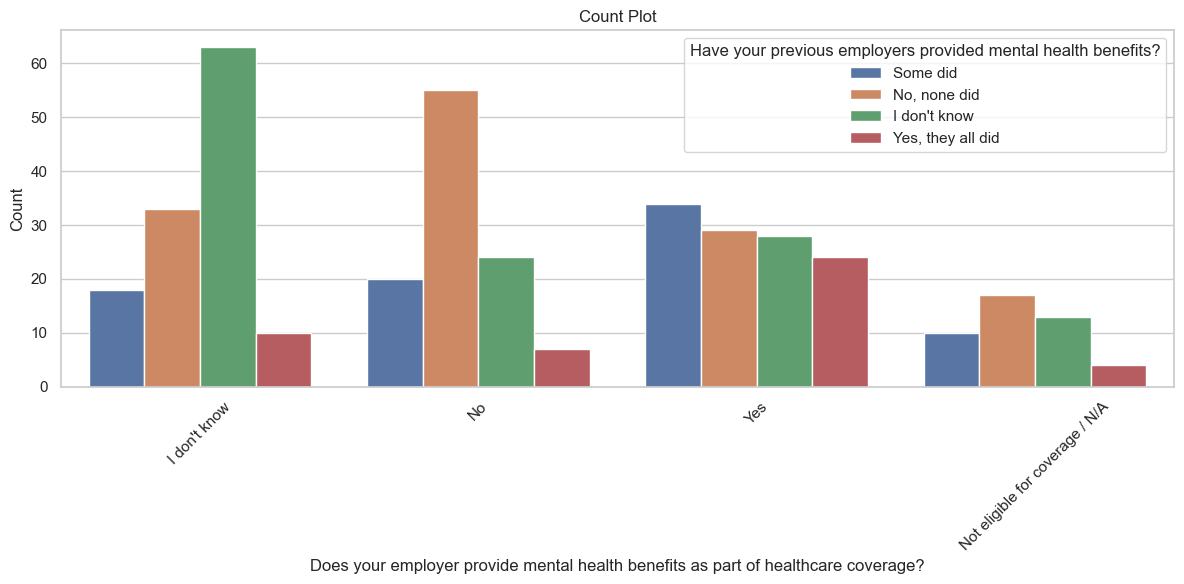

In [122]:
create_count_plot_with_hue(df_c1_middle_no_mh, 'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Have your previous employers provided mental health benefits?',)

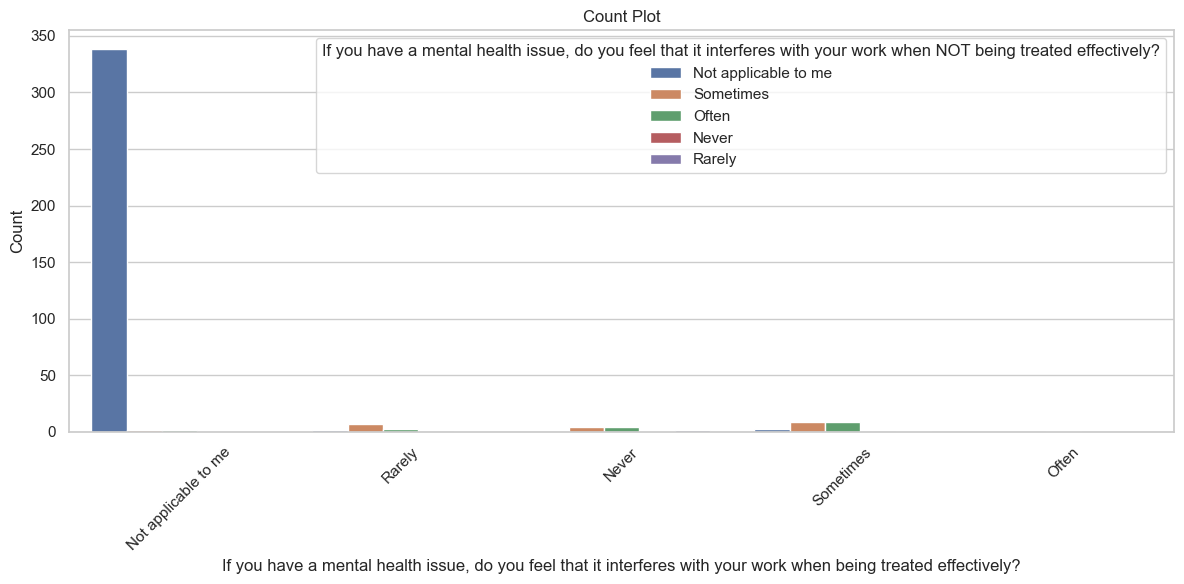

In [123]:
create_count_plot_with_hue(df_c1_middle_no_mh, 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
               'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?')

## Analyzing Cluster 2 - Young Adults MH Diagnosed

- For `Gender`: `0` is male, `1` is female, `2` is other
- For rest of them labels are: `1` for yes, `0` for no and `2` for I don't know or maybe

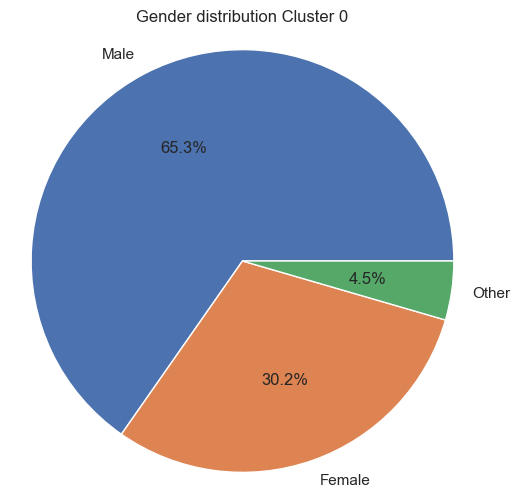

In [124]:
create_pie_chart(df_c2_young_mh, 'What is your gender?', title="Gender distribution Cluster 0")

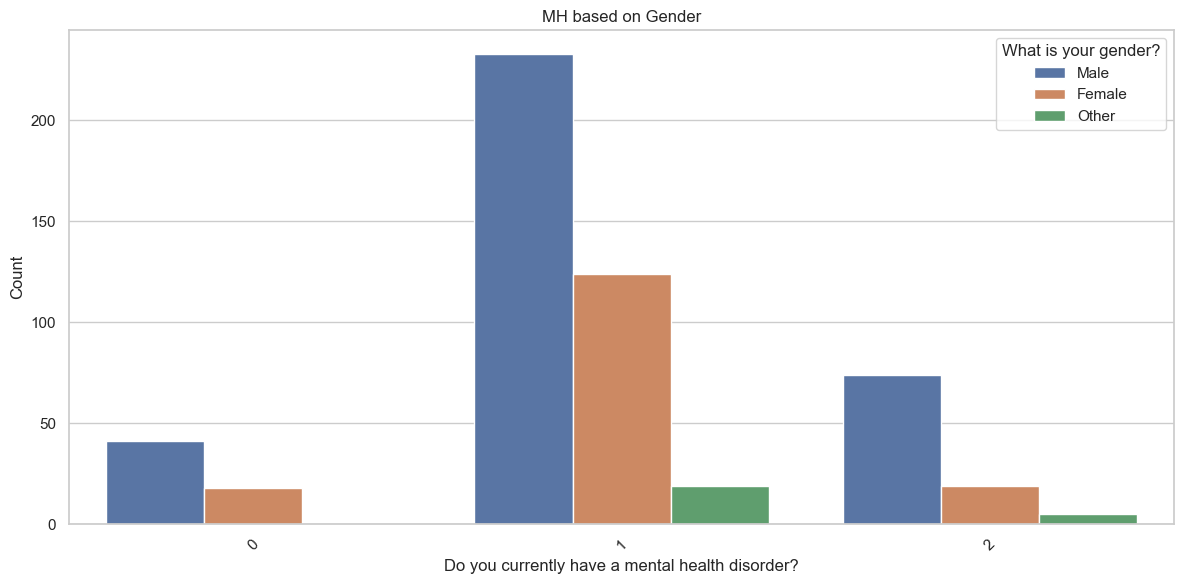

In [126]:
create_count_plot_with_hue(df_c2_young_mh, 'Do you currently have a mental health disorder?',
                           'What is your gender?',
                            'MH based on Gender')

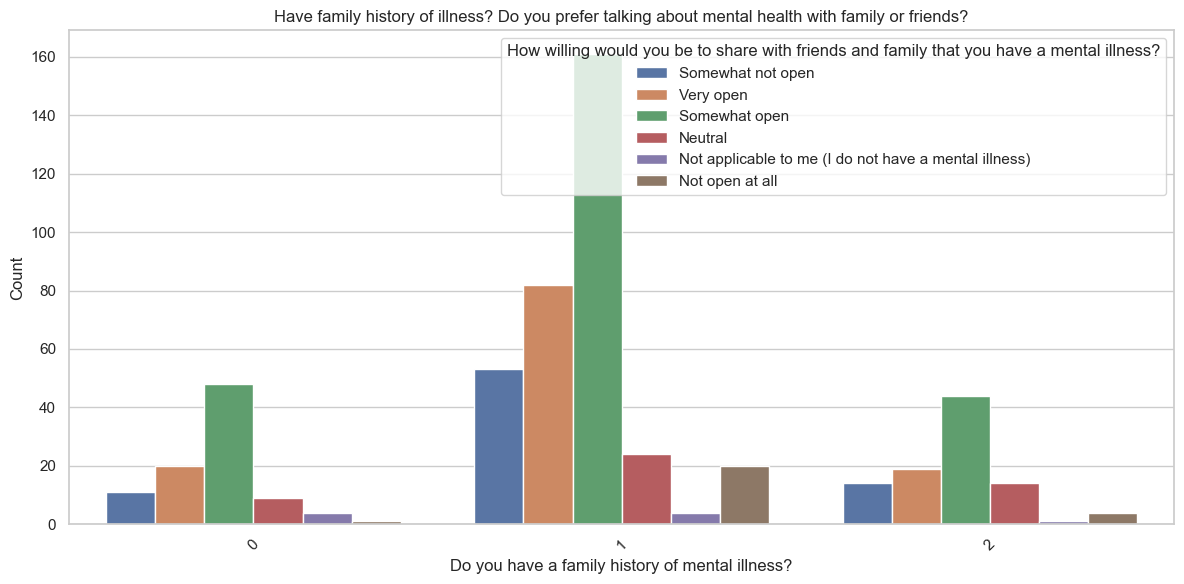

In [127]:
create_count_plot_with_hue(df_c2_young_mh, x_col='Do you have a family history of mental illness?', 
                           hue_col='How willing would you be to share with friends and family that you have a mental illness?',
                           title='Have family history of illness? Do you prefer talking about mental health with family or friends?')

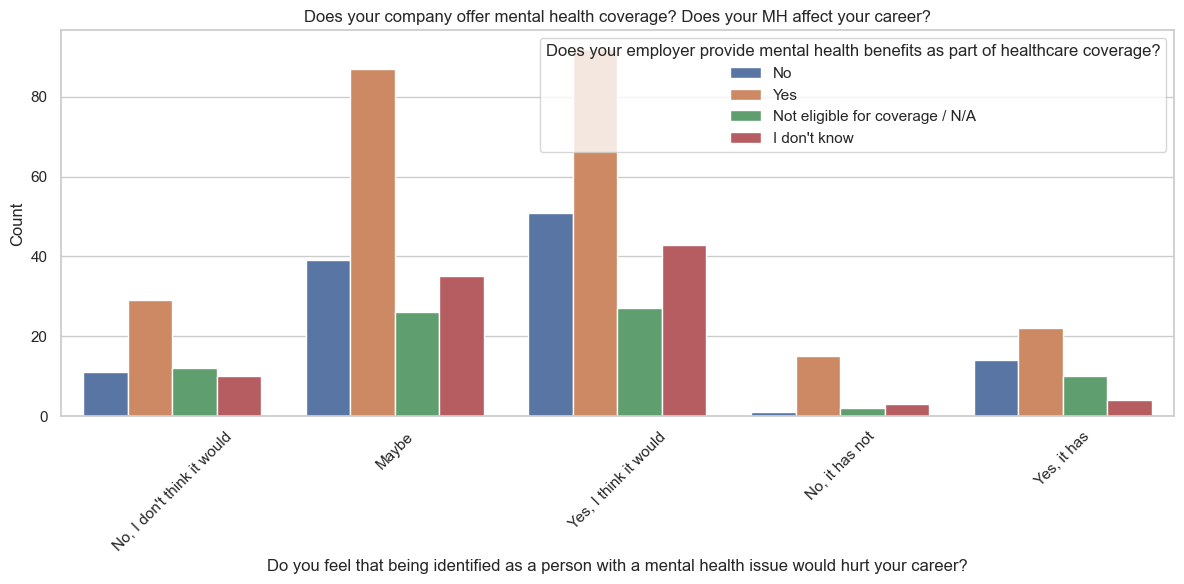

In [128]:
create_count_plot_with_hue(df_c2_young_mh, "Do you feel that being identified as a person with a mental health issue would hurt your career?",
                           'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Does your company offer mental health coverage? Does your MH affect your career?')

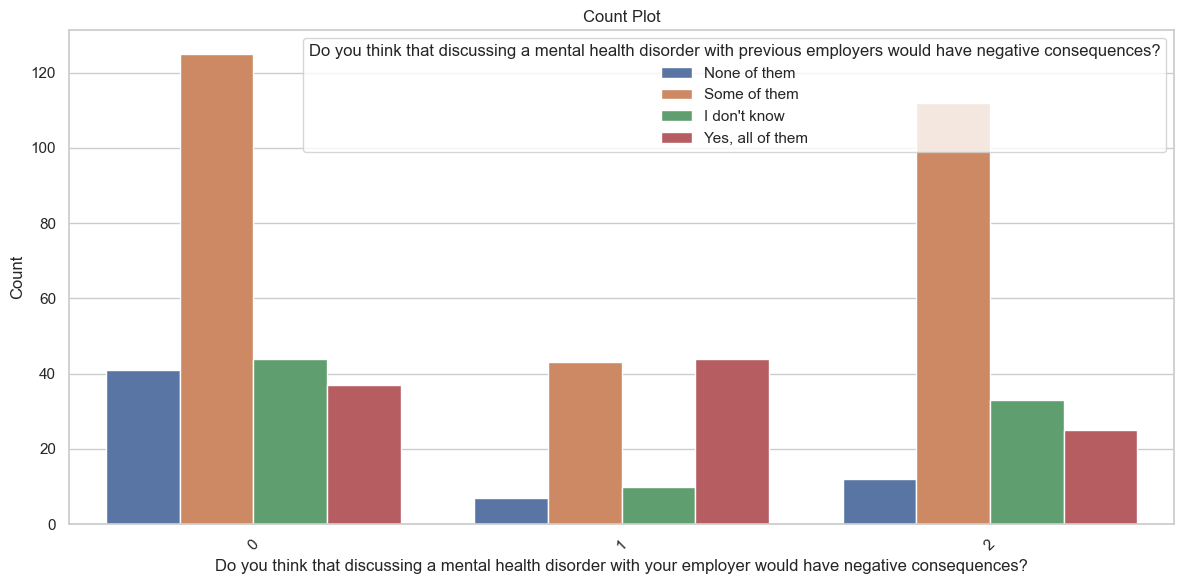

In [129]:
create_count_plot_with_hue(df_c2_young_mh, 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
                           'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',)

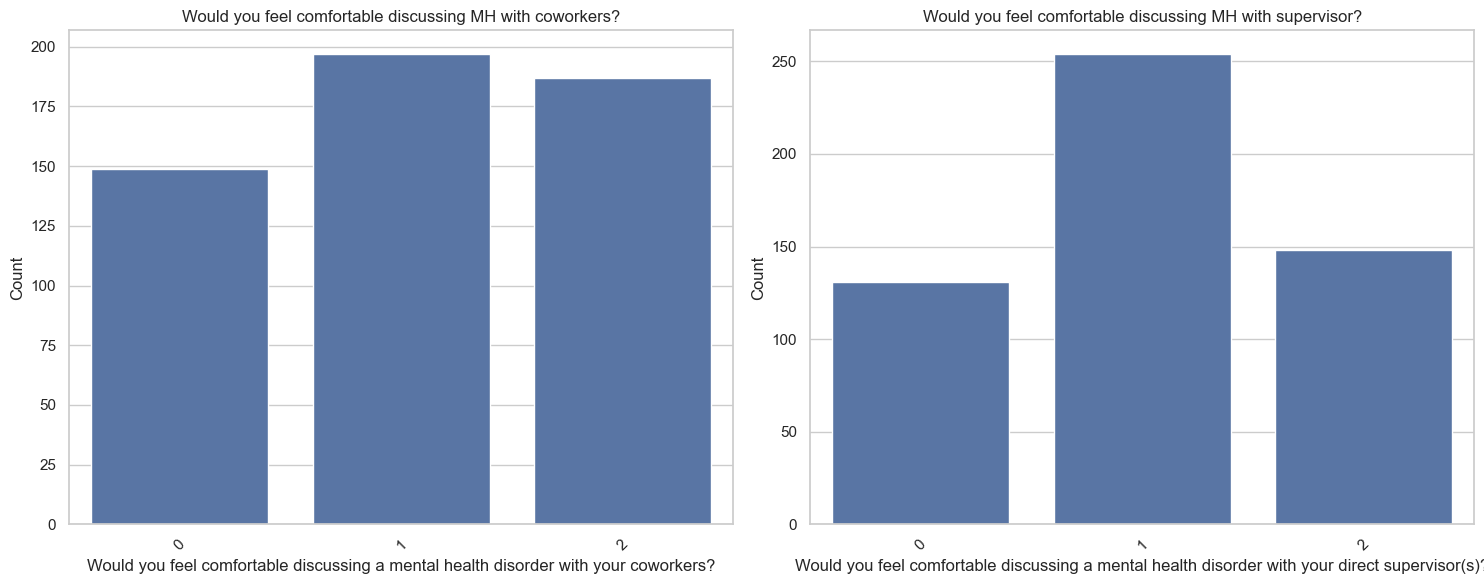

In [130]:
create_separate_countplots(df_c2_young_mh, 'Would you feel comfortable discussing a mental health disorder with your coworkers?',
                           'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                           title1='Would you feel comfortable discussing MH with coworkers?',
                           title2='Would you feel comfortable discussing MH with supervisor?')

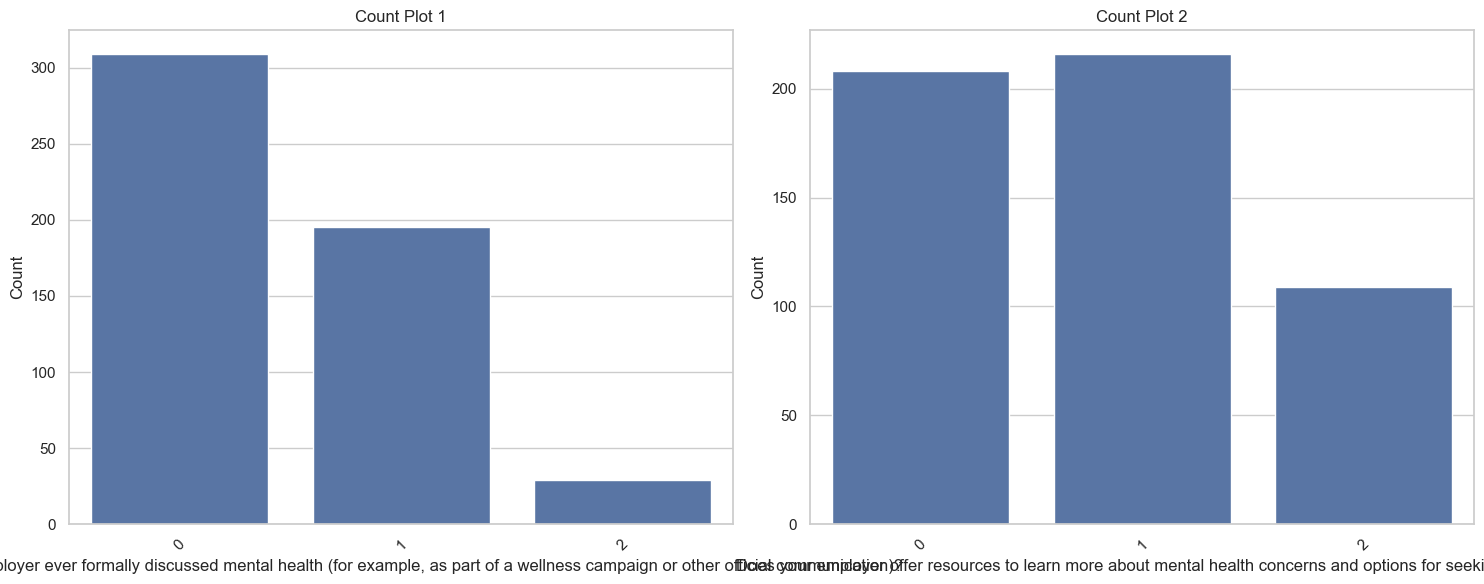

In [131]:
create_separate_countplots(df_c2_young_mh, 
                           'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
                           'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')

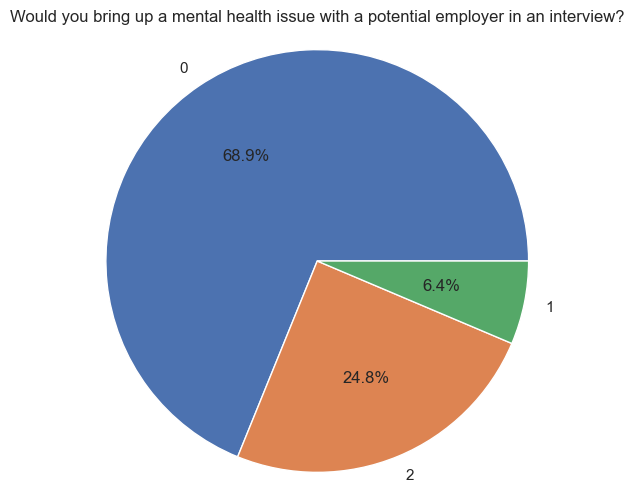

In [132]:
create_pie_chart(df_c2_young_mh, 'Would you bring up a mental health issue with a potential employer in an interview?',
                title='Would you bring up a mental health issue with a potential employer in an interview?')

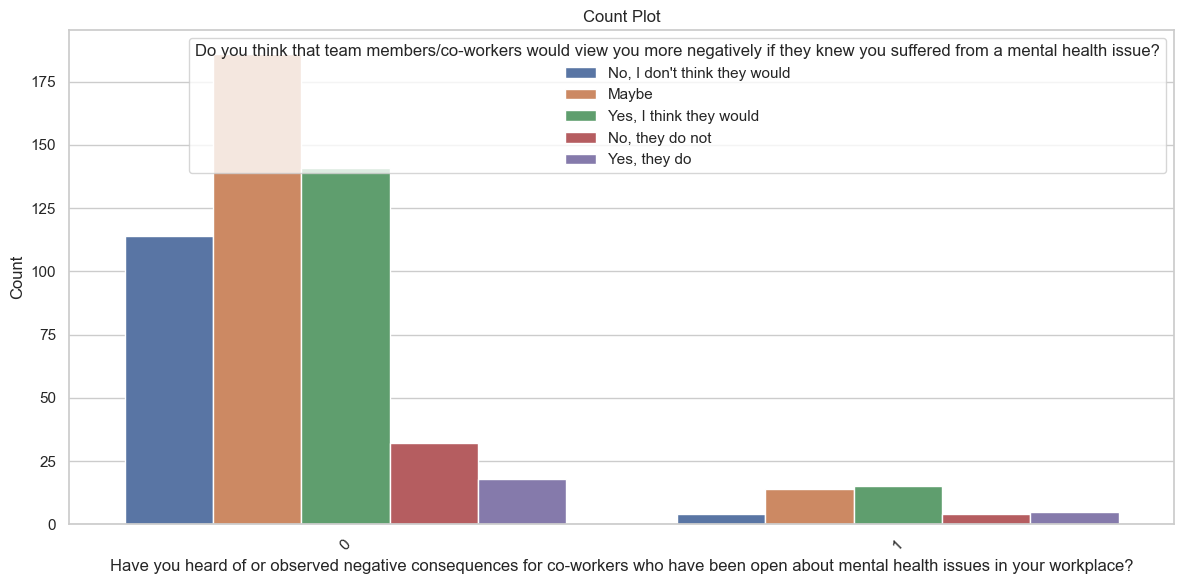

In [133]:
create_count_plot_with_hue(df_c2_young_mh, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
                           'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?')

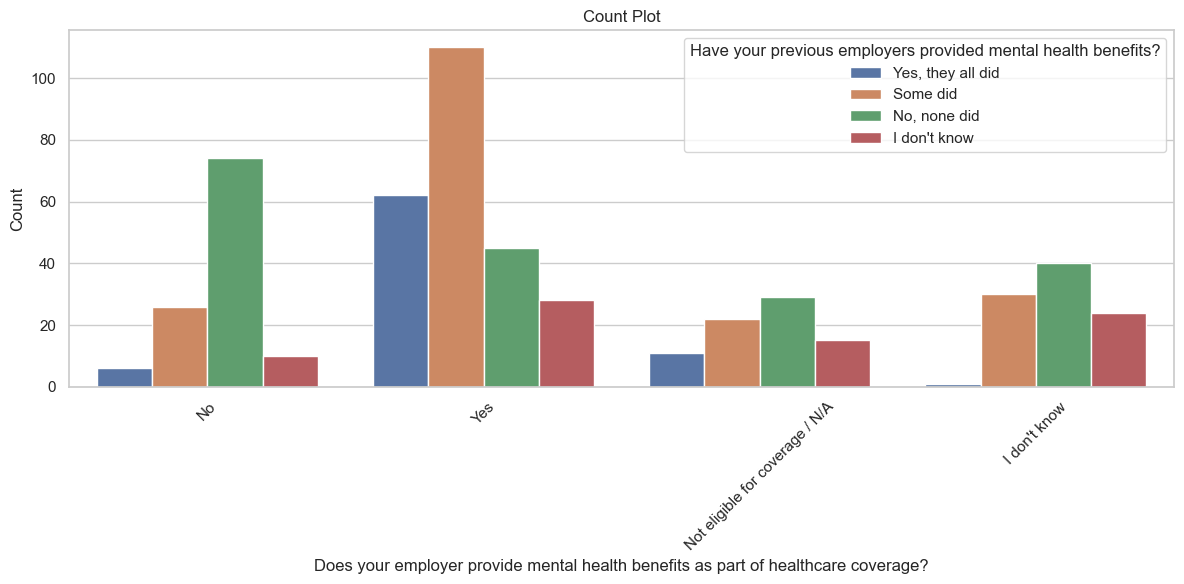

In [134]:
create_count_plot_with_hue(df_c2_young_mh, 'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Have your previous employers provided mental health benefits?',)

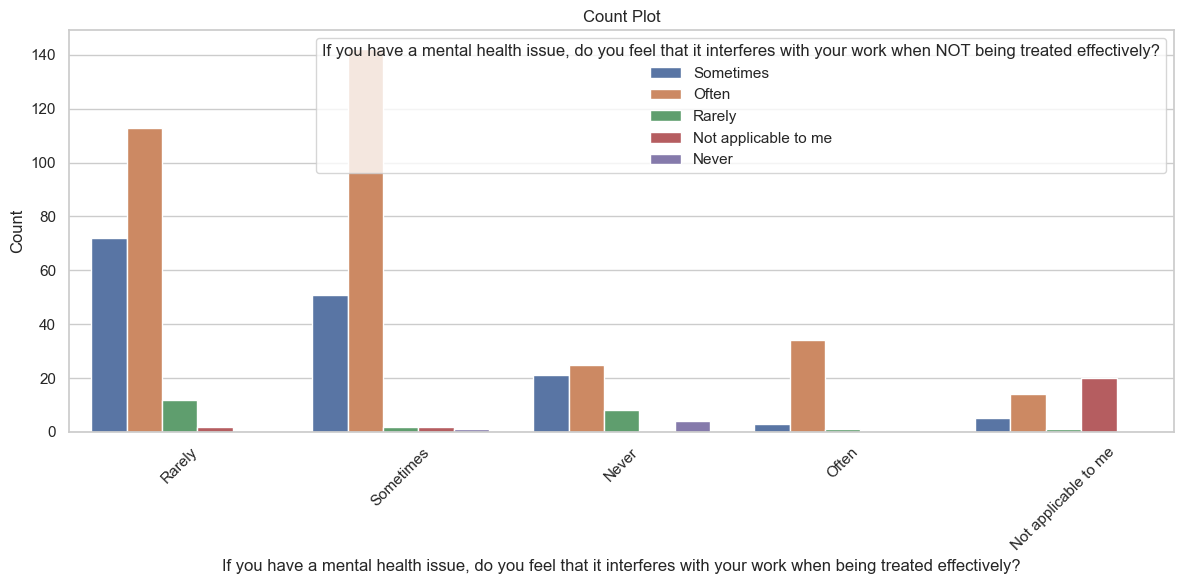

In [135]:
create_count_plot_with_hue(df_c2_young_mh, 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
               'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?')

## Analyzing Cluster 3 - MH Uncertain

- `Note:` They are uncertain about thier MH and thus are potential MH cases that should be looked upon. This cluster can also be used as the target variable and we can predict the MH based on the trained data from other clusters.

- For `Gender`: `0` is male, `1` is female, `2` is other
- For rest of them labels are: `1` for yes, `0` for no and `2` for I don't know or maybe

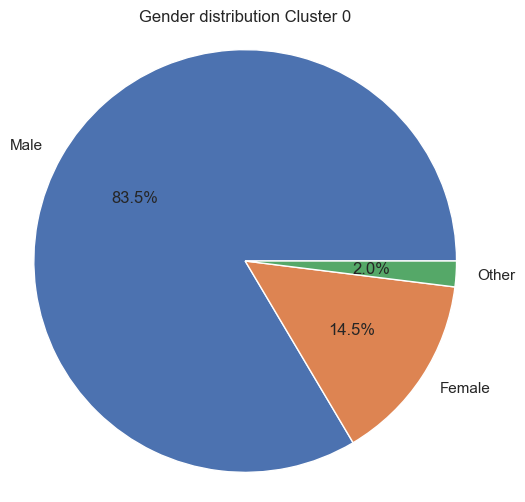

In [136]:
create_pie_chart(df_c3_mh_uncertain, 'What is your gender?', title="Gender distribution Cluster 0")

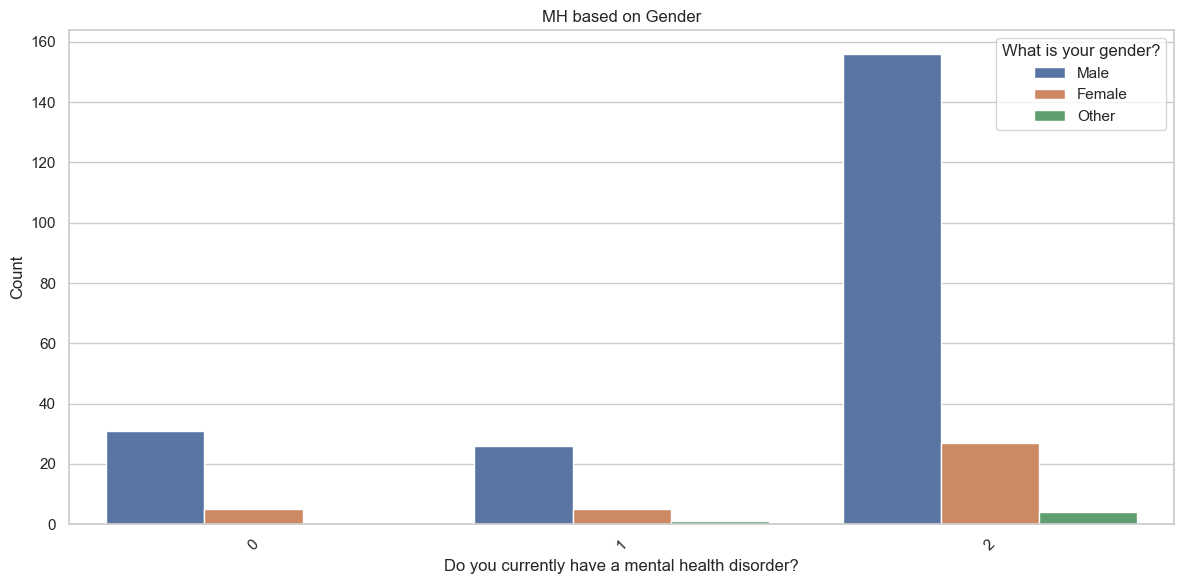

In [137]:
create_count_plot_with_hue(df_c3_mh_uncertain, 'Do you currently have a mental health disorder?',
                           'What is your gender?',
                            'MH based on Gender')

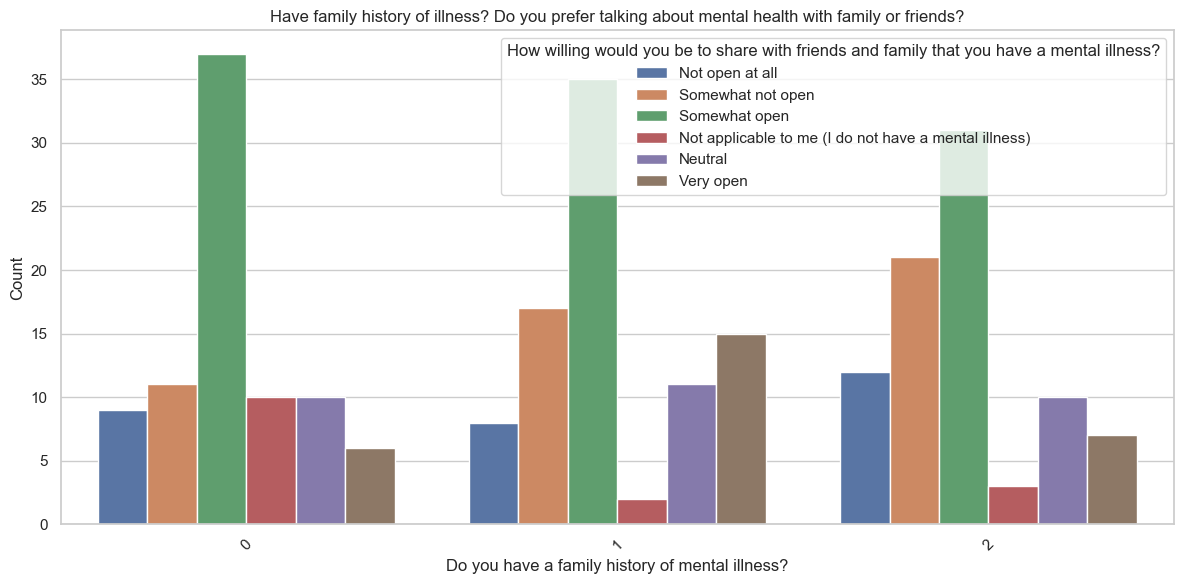

In [138]:
create_count_plot_with_hue(df_c3_mh_uncertain, x_col='Do you have a family history of mental illness?', 
                           hue_col='How willing would you be to share with friends and family that you have a mental illness?',
                           title='Have family history of illness? Do you prefer talking about mental health with family or friends?')

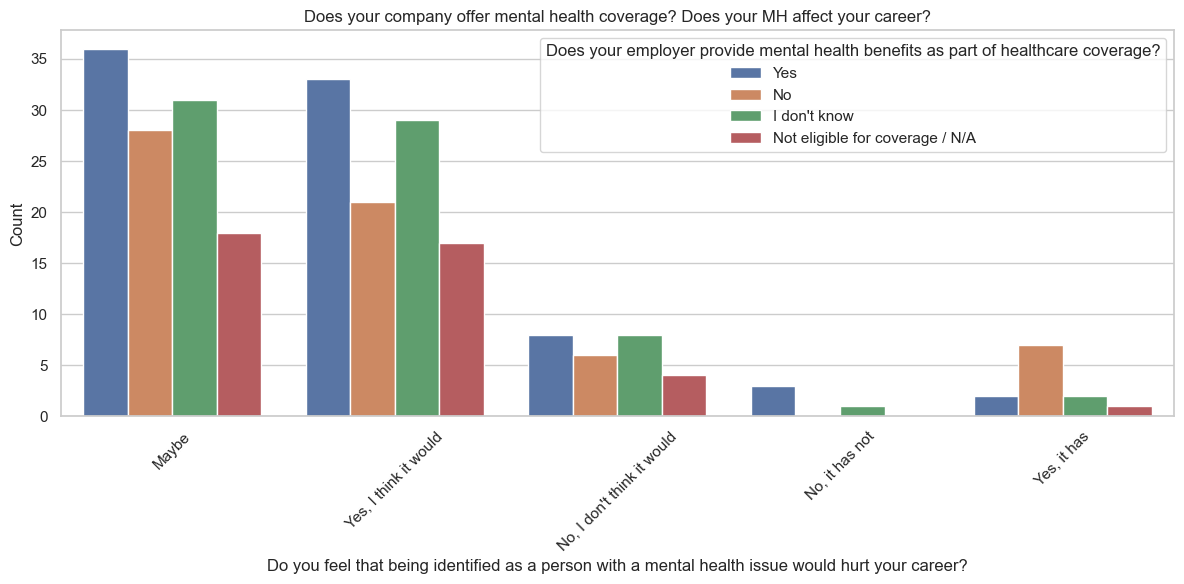

In [139]:
create_count_plot_with_hue(df_c3_mh_uncertain, "Do you feel that being identified as a person with a mental health issue would hurt your career?",
                           'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Does your company offer mental health coverage? Does your MH affect your career?')

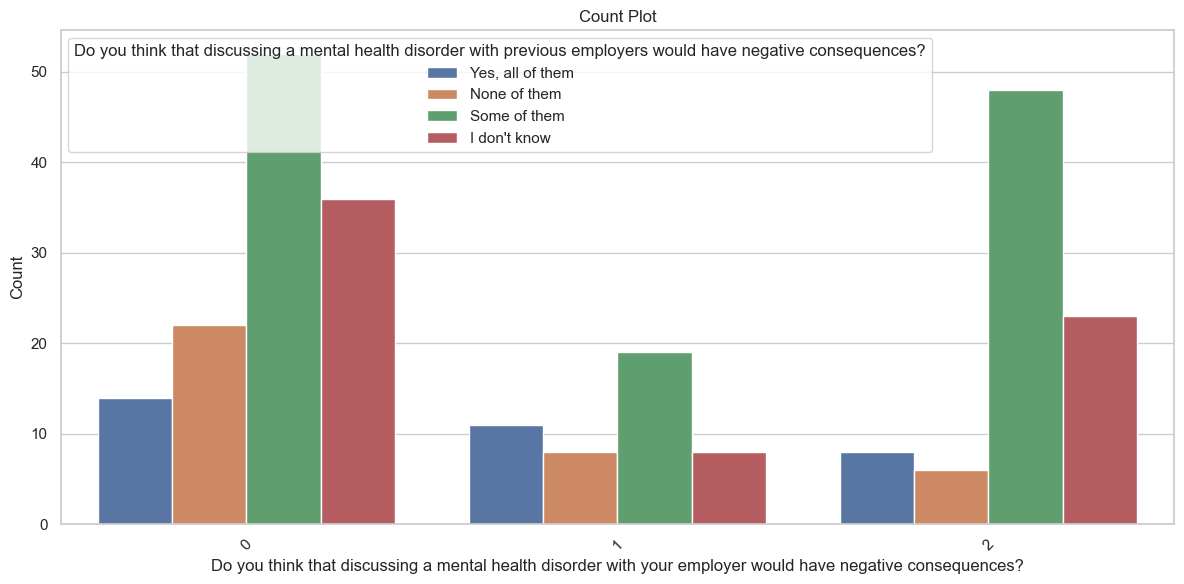

In [140]:
create_count_plot_with_hue(df_c3_mh_uncertain, 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
                           'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',)

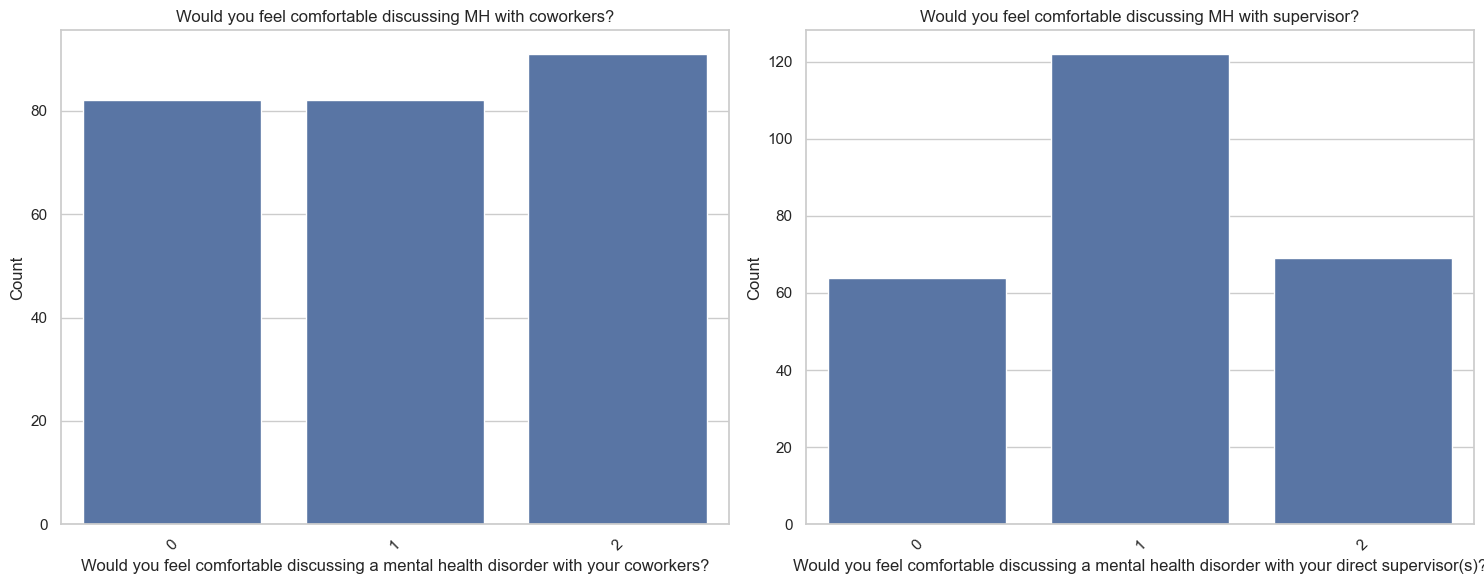

In [141]:
create_separate_countplots(df_c3_mh_uncertain, 'Would you feel comfortable discussing a mental health disorder with your coworkers?',
                           'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                           title1='Would you feel comfortable discussing MH with coworkers?',
                           title2='Would you feel comfortable discussing MH with supervisor?')

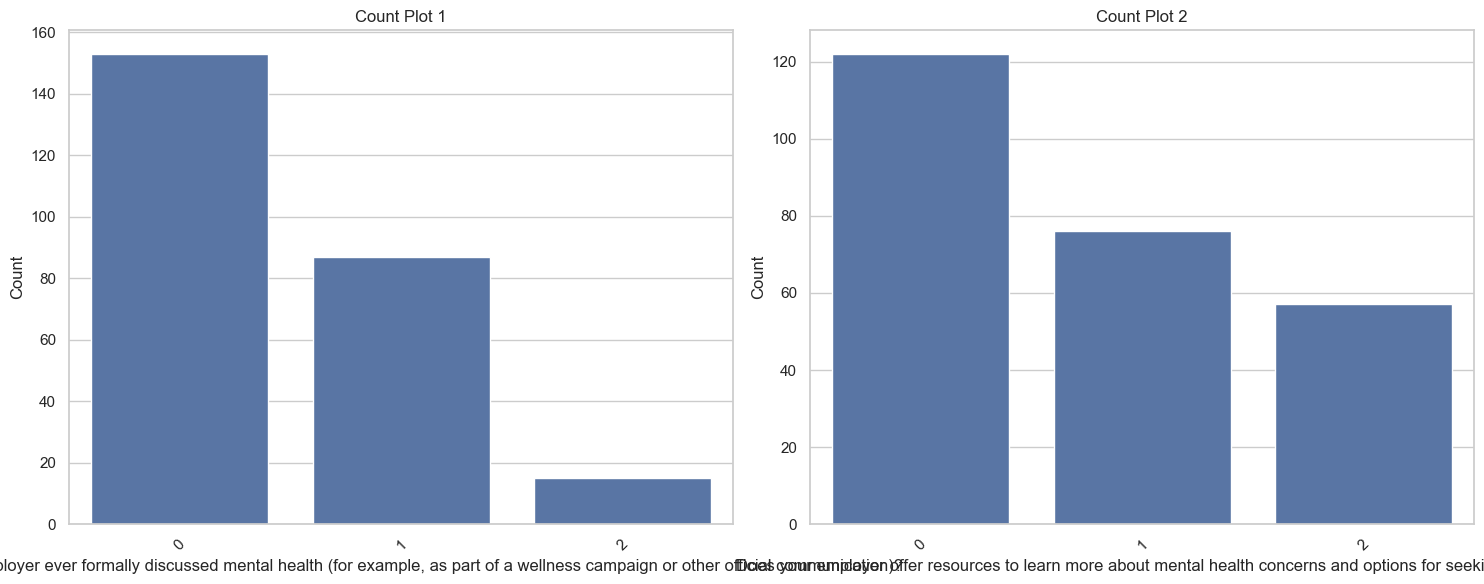

In [142]:
create_separate_countplots(df_c3_mh_uncertain, 
                           'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
                           'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')

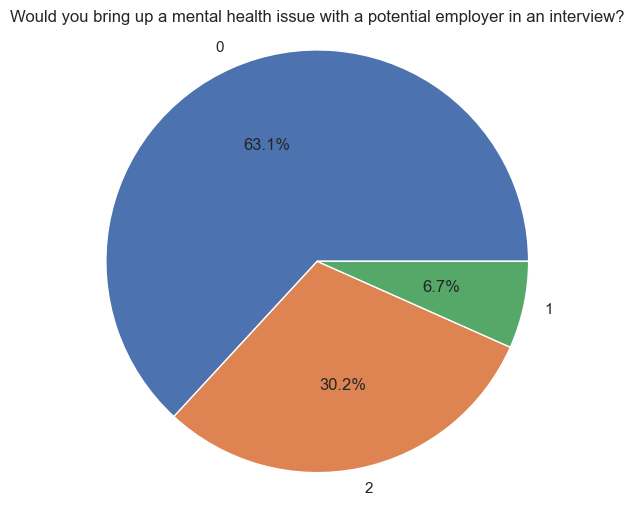

In [143]:
create_pie_chart(df_c3_mh_uncertain, 'Would you bring up a mental health issue with a potential employer in an interview?',
                title='Would you bring up a mental health issue with a potential employer in an interview?')

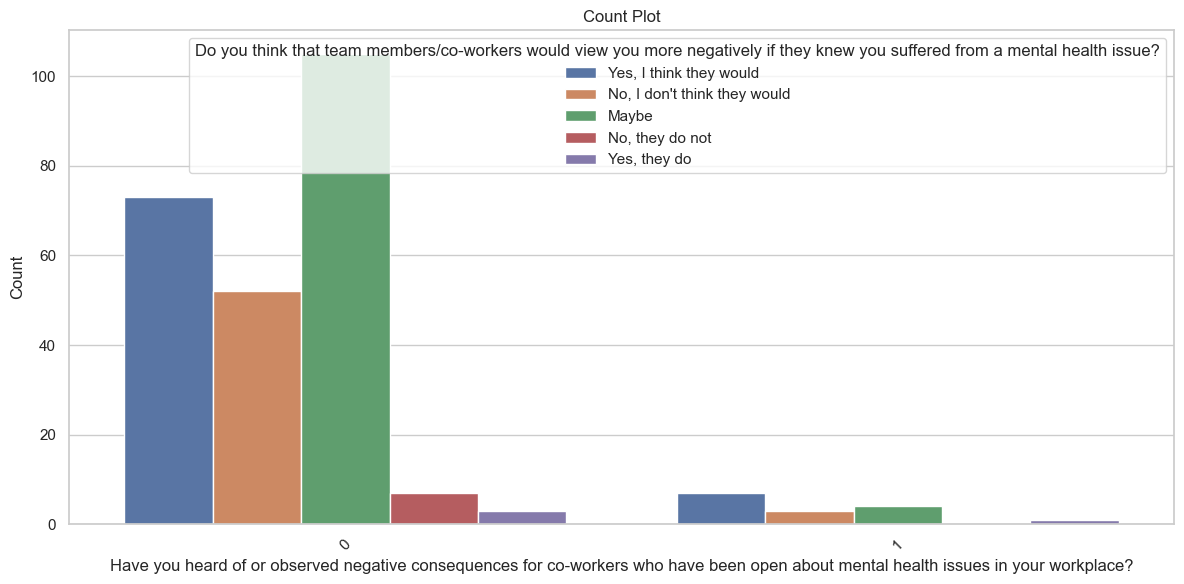

In [144]:
create_count_plot_with_hue(df_c3_mh_uncertain, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
                           'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?')

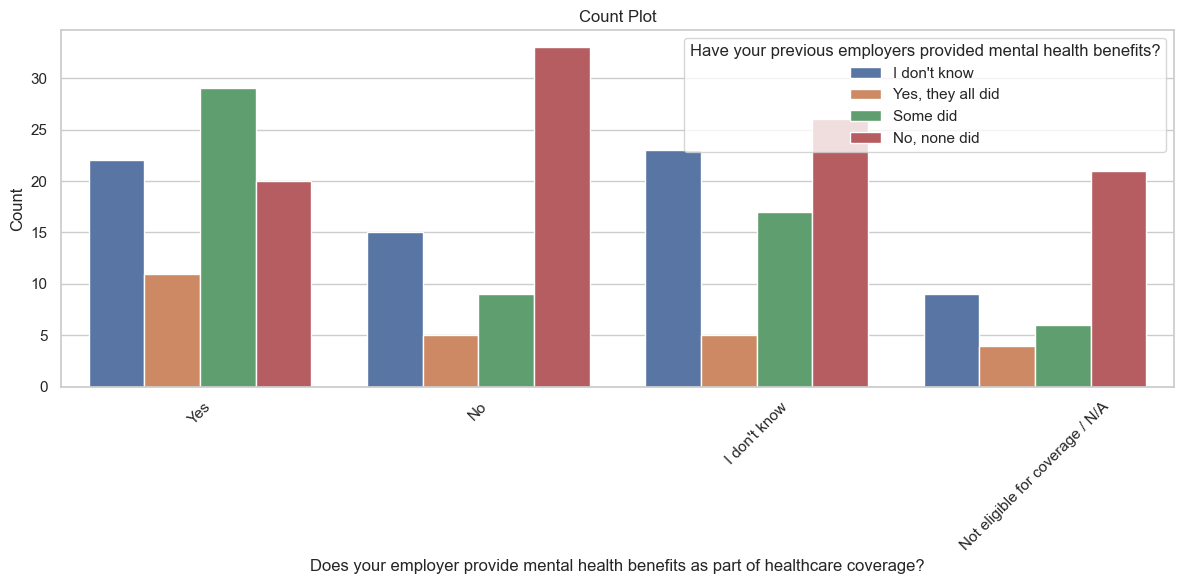

In [145]:
create_count_plot_with_hue(df_c3_mh_uncertain, 'Does your employer provide mental health benefits as part of healthcare coverage?',
                           'Have your previous employers provided mental health benefits?',)

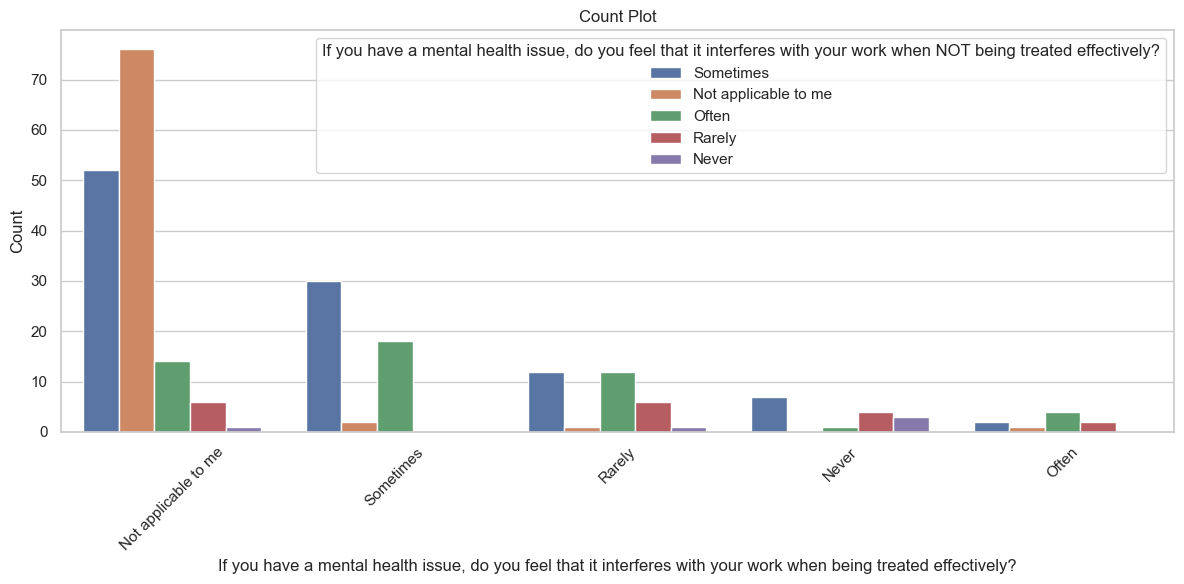

In [146]:
create_count_plot_with_hue(df_c3_mh_uncertain, 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?', 
                           'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?')